In [1]:
import pandas as pd
import numpy as np
import cv2
import IPython.display as ipd
import librosa
import ndjson
import os

# Video and audio dataframe

In [2]:
# import shutil
# from moviepy.editor import VideoFileClip

# # --- CONFIGURATION ---
# # 1. Path to your unzipped RAVDESS folder (the one with 'Actor_01', 'Actor_02'...)
# SOURCE_ROOT = r"D:\project_data\kaggle"

# # 2. Where you want your clean project data to go
# DEST_BASE = r"D:\machine project\kaggle-data"

# # RAVDESS Emotion Map
# # (We map 'sad' and 'fear' to 'neutral' to match your 3-class Audio logic, 
# #  but keep them distinct for the 6-class Video logic)
# EMOTION_MAP = {
#     '01': 'neutral',
#     '02': 'neutral', # Calm = Neutral
#     '03': 'happy',
#     '04': 'sad',
#     '05': 'angry',
#     '06': 'fear',
#     '07': 'disgust',
#     '08': 'surprised'
# }

# def prepare_multimodal_dataset():
#     # 1. Create the folder structure
#     video_root = os.path.join(DEST_BASE, "video")
#     audio_root = os.path.join(DEST_BASE, "audio")
    
#     for emo in EMOTION_MAP.values():
#         os.makedirs(os.path.join(video_root, emo), exist_ok=True)
#         os.makedirs(os.path.join(audio_root, emo), exist_ok=True)

#     print(f"📂 Scanning {SOURCE_ROOT}...")
#     print(f"🎯 Targets: \n   Video -> {video_root}\n   Audio -> {audio_root}\n")
    
#     count = 0
#     errors = 0

#     # 2. Walk through all Actor folders
#     for root, dirs, files in os.walk(SOURCE_ROOT):
#         for file in files:
#             if file.endswith(".mp4"):
#                 try:
#                     # Filename example: 01-01-05-01-01-01-01.mp4
#                     # Code is at index 2
#                     parts = file.split('-')
#                     if len(parts) < 3: continue
                    
#                     emotion_code = parts[2]
#                     if emotion_code not in EMOTION_MAP: continue
                    
#                     target_emotion = EMOTION_MAP[emotion_code]
                    
#                     # Paths
#                     src_video_path = os.path.join(root, file)
                    
#                     # A. HANDLE VIDEO (Copy file)
#                     dst_video_path = os.path.join(video_root, target_emotion, file)
#                     if not os.path.exists(dst_video_path):
#                         shutil.copy2(src_video_path, dst_video_path)

#                     # B. HANDLE AUDIO (Extract from video)
#                     # We save it as .wav with the same name
#                     wav_filename = file.replace(".mp4", ".wav")
#                     dst_audio_path = os.path.join(audio_root, target_emotion, wav_filename)
                    
#                     if not os.path.exists(dst_audio_path):
#                         # Extract audio using MoviePy
#                         clip = VideoFileClip(src_video_path)
#                         if clip.audio is not None:
#                             clip.audio.write_audiofile(dst_audio_path, verbose=False, logger=None)
#                             clip.close()
                    
#                     count += 1
#                     if count % 50 == 0: print(f"   Processed {count} files...")

#                 except Exception as e:
#                     print(f"❌ Error processing {file}: {e}")
#                     errors += 1

#     print(f"\n✅ DONE! Processed {count} files.")
#     print(f"   Video dataset ready at: {video_root}")
#     print(f"   Audio dataset ready at: {audio_root}")

# if __name__ == "__main__":
#     prepare_multimodal_dataset()

In [3]:
EMOTION_MAP = {
    '01': 'neutral',
    '02': 'neutral', # Calm = Neutral
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust',
    '08': 'surprised'
}

In [4]:
import mediapipe as mp

casc_path = (r"C:\\Users\\PC\\anaconda3\\pkgs\\opencv-4.12.0-py312h6fcf9f4_0\\Library\\etc\\haarcascades\\haarcascade_frontalface_default.xml")

class EmotionFeatureExtractor:
    def __init__(self):
        self.mp_face_mesh = mp.solutions.face_mesh
        
        # --- CONFIGURATION FOR LINEAR TRACKING ---
        self.face_mesh = self.mp_face_mesh.FaceMesh(
            static_image_mode=False,        # FALSE = Enable Linear Tracking (Faster & Smoother)
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5     # Tracking needs this to be balanced
        )

    def reset(self):
        self.face_mesh.reset()

    def get_features(self, frame):
        # 1. Convert to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # 2. Process (Updates the internal tracker)
        results = self.face_mesh.process(rgb_frame)
        
        if not results.multi_face_landmarks:
            return None
        
        landmarks = results.multi_face_landmarks[0]
        
        # 3. Extract & Normalize (Same as before)
        coords = []
        for lm in landmarks.landmark:
            coords.append(lm.x)
            coords.append(lm.y)
        
        coords = np.array(coords).reshape(-1, 2)
        
        # Center & Scale
        nose_x, nose_y = coords[1] 
        coords[:, 0] -= nose_x
        coords[:, 1] -= nose_y
        
        dist = np.linalg.norm(coords[234] - coords[454]) + 1e-6
        coords /= dist
        
        return coords.flatten()

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [5]:
def process_video_dataset_kaggle():
    
    data_rows = []
    # Initialize Extractor (Make sure static_image_mode=False internally!)
    extractor = EmotionFeatureExtractor()
    
    ROOT_DIR = r"D:\Manager-angry-meter\kaggle-data\video"
    
    print(f"📂 Scanning recursive directories in: {ROOT_DIR}")

    for root, dirs, files in os.walk(ROOT_DIR):
        for filename in files:
            if filename.lower().endswith(('.mp4', '.avi')):
                
                # 1. Extract Label (Specific to Kaggle naming convention)
                try:
                    parts = filename.split('-')
                    if len(parts) >= 3:
                        code = parts[2]
                        emotion_label = EMOTION_MAP.get(code, 'unknown')
                    else:
                        emotion_label = 'unknown'
                except:
                    continue

                if emotion_label == 'unknown': continue

                video_path = os.path.join(root, filename)
                video_id = filename
                
                print(f"   Processing: {video_id} -> {emotion_label}")
                
                # --- LOGIC ALIGNMENT: RESET TRACKER ---
                extractor.reset()
                
                cap = cv2.VideoCapture(video_path)
                
                while True:
                    ret, frame = cap.read()
                    if not ret: break
                    
                    # --- LOGIC ALIGNMENT: PROCESS EVERY FRAME ---
                    features = extractor.get_features(frame)
                    
                    # --- LOGIC ALIGNMENT: SAVE EVERY VALID FRAME ---
                    if features is not None:
                        # Row: [ID, Label, Features...]
                        row = [video_id, emotion_label] + features.tolist()
                        data_rows.append(row)
                
                cap.release()

    return data_rows

# --- EXAMPLE USAGE TO BUILD DATAFRAME ---
# DATA_ROWS_KAGGLE = process_video_dataset_kaggle()

# if len(DATA_ROWS_KAGGLE) > 0:
#     num_features = len(DATA_ROWS_KAGGLE[0]) - 2  # Minus ID and Label
#     feature_cols = [f'pixel_{i}' for i in range(num_features)]
#     column_names = ['id', 'emotion'] + feature_cols 
    
#     df_kaggle = pd.DataFrame(DATA_ROWS_KAGGLE, columns=column_names)
#     print(f"✅ Kaggle Dataframe Shape: {df_kaggle.shape}")

In [6]:
CACHE_FILE_KAGGLE = "video_features_kaggle.pkl" # Unique name

if os.path.exists(CACHE_FILE_KAGGLE):
    print(f"🚀 Found '{CACHE_FILE_KAGGLE}'! Loading...")
    df_kaggle = pd.read_pickle(CACHE_FILE_KAGGLE)
else:
    print(f"🐢 Starting Kaggle Processing...")
    
    # 1. Run Extraction
    # Make sure you defined this function in the previous cell!
    DATA_ROWS = process_video_dataset_kaggle() 
    
    # 2. Safety Check
    if len(DATA_ROWS) > 0:
        # Kaggle rows = [ID, Emotion, Feat1, Feat2...] (Minus 2 columns)
        num_features = len(DATA_ROWS[0]) - 2 
        feature_cols = [f'pixel_{i}' for i in range(num_features)]
        column_names = ['id', 'emotion'] + feature_cols
        
        df_kaggle = pd.DataFrame(DATA_ROWS, columns=column_names)
        
        print("💾 Saving Kaggle data...")
        df_kaggle.to_pickle(CACHE_FILE_KAGGLE)
    else:
        print("❌ CRITICAL: No Kaggle data found. Check your ROOT_DIR path!")
        df_kaggle = pd.DataFrame()

print("\n✅ DONE.")
print(f"   Kaggle Shape:   {df_kaggle.shape}")

🚀 Found 'video_features_kaggle.pkl'! Loading...

✅ DONE.
   Kaggle Shape:   (53553, 958)


In [7]:
# DATA_ROWS = process_video_dataset(skip_frames=2)

# if len(DATA_ROWS) > 0:
#     # Determine the number of feature columns (Total length - 2 for 'id')
#     num_features = len(DATA_ROWS[0]) - 2 # Minus 2 because of ID and Emotion
#     feature_cols = [f'pixel_{i}' for i in range(num_features)]

#     # DEFINE COLUMNS EXPLICITLY
#     column_names = ['id', 'emotion'] + feature_cols 

#     df_final = pd.DataFrame(DATA_ROWS, columns=column_names)
    
#     print("\n--- Final DataFrame Status ---")
#     print(f"Total rows (frames) extracted: {df_final.shape[0]}")
#     print(f"Total features per row: {df_final.shape[1]}") # Should be 4098
#     print(df_final[['id', 'pixel_0', 'pixel_1']].head())

In [8]:
# df_final = pd.merge(
#     df_features, 
#     df_meta,
#     on='id', 
#     how='left'
# )

# print(f"Original Feature Shape: {df_features.shape}")
# print(f"Final Merged Shape:     {df_final.shape}")
# print("\nFirst 5 rows of the merged data, showing the copied emotion:")
# print(df_final[['id', 'emotion', 'pixel_0']].head())
# df_final['emotion'].value_counts()

# audio dataframe

In [9]:
class AudioFeatureExtractor:
    def __init__(self):
        self.sample_rate = 22050
        
        # --- LOGIC UPDATE: Same as the improved extractor ---
        self.duration = 2.0  # Look at 2 seconds at a time (Context)
        self.step = 0.5      # Slide forward by 0.5 seconds (Overlap)
        self.n_mfcc = 40

    def get_features(self, audio_path):
        try:
            # 1. Load Audio
            y, sr = librosa.load(audio_path, sr=self.sample_rate)
            
            # 2. Trim Silence
            y_trimmed, _ = librosa.effects.trim(y, top_db=20)
            
            # If file was empty or pure silence, return nothing
            if len(y_trimmed) == 0:
                return []
            
            # Calculate samples needed
            window_samples = int(self.duration * sr)
            step_samples = int(self.step * sr)
            total_samples = len(y_trimmed)
            
            vectors = []
            
            # 3. SLIDING WINDOW LOGIC
            # If audio is shorter than 2s, we pad it.
            # If longer, we slide through it with overlap.
            
            if total_samples < window_samples:
                # Case A: Short Audio -> Pad with zeros
                padding_needed = window_samples - total_samples
                y_chunk = np.pad(y_trimmed, (0, padding_needed))
                vectors.append(self._extract_stats(y_chunk, sr))
            else:
                # Case B: Long Audio -> Slide Window
                # We add +1 to ensure we capture the final window if it fits exactly
                for start in range(0, total_samples - window_samples + 1, step_samples):
                    end = start + window_samples
                    chunk = y_trimmed[start:end]
                    
                    # Extract features for this window
                    vectors.append(self._extract_stats(chunk, sr))
                    
            return vectors

        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            return []

    def _extract_stats(self, y, sr):
        # --- LOGIC UPDATE: Rich Feature Set ---
        # (MFCC + Pitch + Roughness + Shouting)
        
        # 1. MFCC (Voice Texture)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)
        
        # 2. Chroma (Pitch/Tonal content)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        
        # 3. Spectral Contrast (Roughness)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        
        # 4. Zero Crossing Rate (Noisiness/Shouting)
        zcr = librosa.feature.zero_crossing_rate(y)
        
        # --- AGGREGATE STATS (Mean & Std Dev) ---
        features = []
        
        # Add Mean and Std for all feature types
        for feat in [mfcc, chroma, contrast, zcr]:
            features.append(np.mean(feat, axis=1))
            features.append(np.std(feat, axis=1))
            
        # Flatten into one long vector
        return np.concatenate(features)

In [10]:
def process_audio_dataset():
    data_rows = []
    
    # Ensure you have your AudioFeatureExtractor class defined above!
    extractor = AudioFeatureExtractor() 
    
    # UPDATE THIS to your Kaggle Audio folder
    ROOT_DIR = r"D:\Manager-angry-meter\kaggle-data\audio"

    print(f"📂 Scanning recursive directories in: {ROOT_DIR}")
    print("✂️  Slicing audio files into segments...")

    # --- 1. USE OS.WALK (Recursive Search) ---
    for root, dirs, files in os.walk(ROOT_DIR):
        for filename in files:
            if filename.lower().endswith(('.wav', '.mp3', '.mp4')):
                
                # --- 2. EXTRACT EMOTION FROM FILENAME ---
                # Format: 03-01-05-01-01-01-01.wav
                try:
                    parts = filename.split('-')
                    if len(parts) >= 3:
                        code = parts[2]
                        emotion_label =EMOTION_MAP.get(code, 'unknown')
                    else:
                        emotion_label = 'unknown'
                except:
                    emotion_label = 'unknown'

                if emotion_label == 'unknown': continue

                file_path = os.path.join(root, filename)
                original_id = filename 

                # --- EXTRACT FEATURES ---
                # Returns list of vectors (one for each 0.5s chunk)
                chunk_list = extractor.get_features(file_path)
                
                if chunk_list:
                    for vector in chunk_list:
                        # --- 3. BUILD ROW WITH EMOTION ---
                        # Format: [ID, EMOTION, Feature_1, Feature_2...]
                        row = [original_id, emotion_label] + vector.tolist()
                        data_rows.append(row)

    print(f"✅ Processing Complete. Generated {len(data_rows)} total segments.")
    return data_rows

In [11]:
AUDIO_DATA_ROWS = process_audio_dataset()

if len(AUDIO_DATA_ROWS) > 0:
    # Calculate feature columns (Total length - 2 for 'id' and 'emotion')
    num_features = len(AUDIO_DATA_ROWS[0]) - 2
    
    feature_cols = [f'mfcc_{i}' for i in range(num_features)]
    
    # --- DEFINE COLUMNS EXPLICITLY ---
    column_names = ['id', 'emotion'] + feature_cols
    
    df_Audio = pd.DataFrame(AUDIO_DATA_ROWS, columns=column_names)
    
    print(f"\nExample of Segmented Data:")
    print(df_Audio.head())
    print(f"Total Segments: {len(df_Audio)}")
    print(f"Emotion Counts:\n{df_Audio['emotion'].value_counts()}")
else:
    print("❌ Error: No audio segments were generated. Check your ROOT_DIR.")

📂 Scanning recursive directories in: D:\Manager-angry-meter\kaggle-data\audio
✂️  Slicing audio files into segments...


c:\Users\PC\anaconda3\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


✅ Processing Complete. Generated 1207 total segments.

Example of Segmented Data:
                         id emotion      mfcc_0     mfcc_1     mfcc_2  \
0  01-01-05-01-01-01-01.wav   angry -402.956055  75.259445  -6.759887   
1  01-01-05-01-01-01-02.wav   angry -445.781647  70.724022 -22.633474   
2  01-01-05-01-01-01-03.wav   angry -476.068054  92.365135  10.084575   
3  01-01-05-01-01-01-04.wav   angry -446.963440  59.885502 -20.256659   
4  01-01-05-01-01-02-01.wav   angry -364.847107  69.648979  -7.049018   

      mfcc_3     mfcc_4     mfcc_5     mfcc_6     mfcc_7  ...   mfcc_110  \
0  19.964931  -5.159092  -6.579600  -7.443521   0.228306  ...  41.396125   
1   8.530368 -13.395951 -10.976827  -6.770191 -17.617781  ...  38.492131   
2  23.447985   3.723260  -8.903419 -12.500783  -8.851965  ...  42.313520   
3   5.426655 -17.499435 -12.566243 -12.518078 -23.689978  ...  39.316353   
4  16.514681 -10.613578  -7.778811 -11.969784 -11.818856  ...  43.166939   

   mfcc_111  mfcc_112 

# Video data cleaning

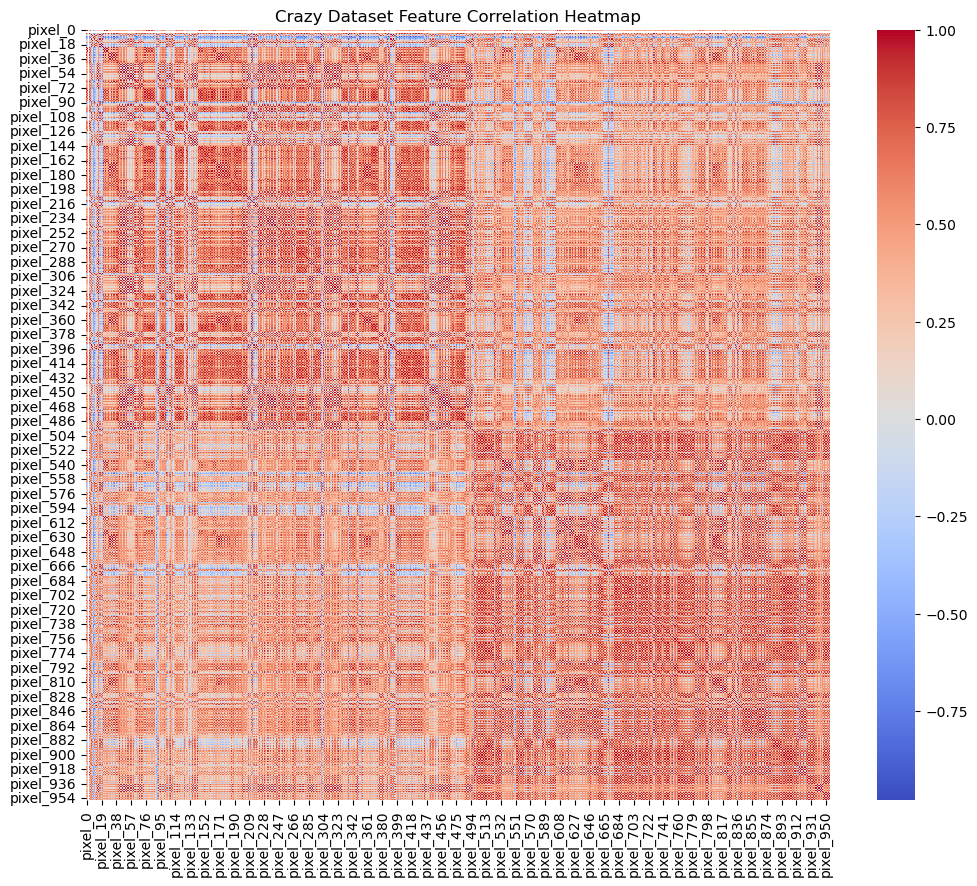

In [12]:
df_heatmap = df_kaggle.drop(columns=['id', 'emotion'])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
correlation_matrix = df_heatmap.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Crazy Dataset Feature Correlation Heatmap')
plt.show()

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 1. Create a copy so we don't mess up the original data
target_dummies = pd.get_dummies(df_kaggle['emotion'], prefix='target')

df_kaggle = df_kaggle.drop(columns=['id', 'emotion'])

df_corr = pd.concat([df_kaggle, target_dummies], axis=1)

corr_matrix = df_corr.corr()

feature_cols = df_kaggle.columns
target_cols = target_dummies.columns

target_correlations = corr_matrix.loc[feature_cols, target_cols].abs()
max_score = target_correlations.max(axis=1)

features_to_drop = max_score[max_score < 0.2 ].index.tolist()
print(f"Dropping {len(features_to_drop)} features with low correlation to targets.")

df_kaggle = df_kaggle.drop(columns=features_to_drop)

Dropping 466 features with low correlation to targets.


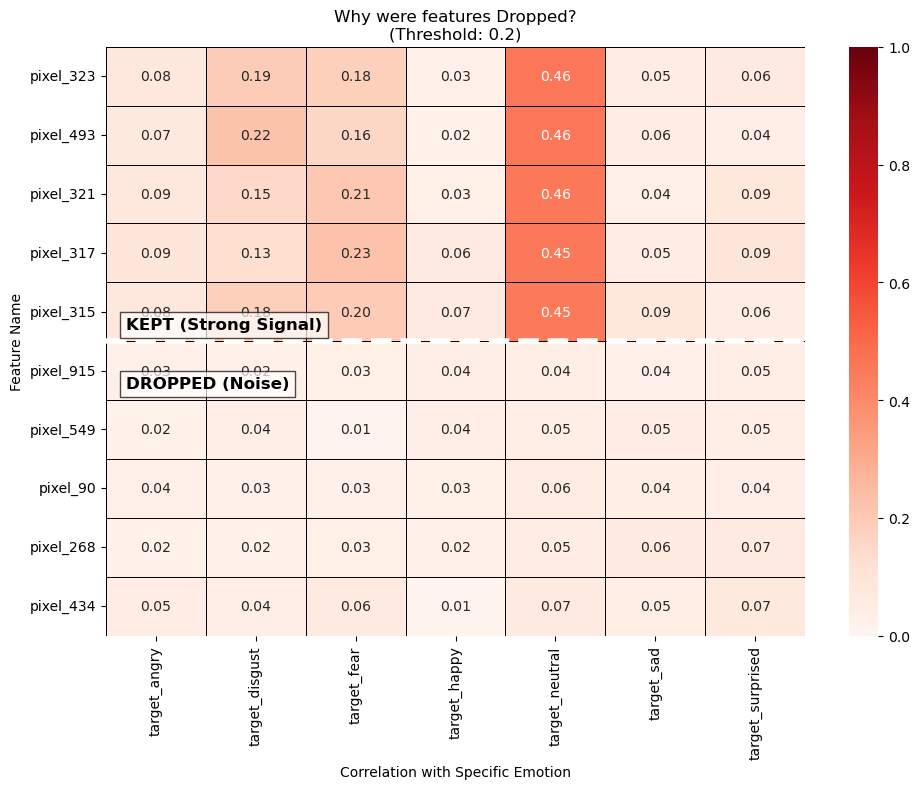

In [14]:
kept_features = max_score[max_score >= 0.2].sort_values(ascending=False).head(5).index.tolist()
dropped_features = max_score[max_score < 0.2].sort_values(ascending=True).head(5).index.tolist()
features_to_plot = kept_features + dropped_features

plot_data = target_correlations.loc[features_to_plot]

plt.figure(figsize=(10, 8))
sns.heatmap(
        plot_data, 
        annot=True,       # Show the numbers
        fmt=".2f",        # 2 decimal places
        cmap='Reds',  # Red = High, Blue = Low
        vmin=0, vmax=1,   # Scale from 0 to 1
        linewidths=0.5,
        linecolor='black'
    )

plt.axhline(len(kept_features), color='white', linewidth=4, linestyle='--')
plt.text(0.2, len(kept_features) - 0.2, "KEPT (Strong Signal)", color='black', fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
plt.text(0.2, len(kept_features) + 0.8, "DROPPED (Noise)", color='black', fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))

plt.title(f"Why were features Dropped?\n(Threshold: {0.2})")
plt.xlabel("Correlation with Specific Emotion")
plt.ylabel("Feature Name")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [15]:
corr_matrix = df_kaggle.corr().abs()

mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper = corr_matrix.where(mask)

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"✅ Dropped {len(to_drop)} redundant features.")
df_kaggle = df_kaggle.drop(columns=to_drop)

✅ Dropped 453 redundant features.


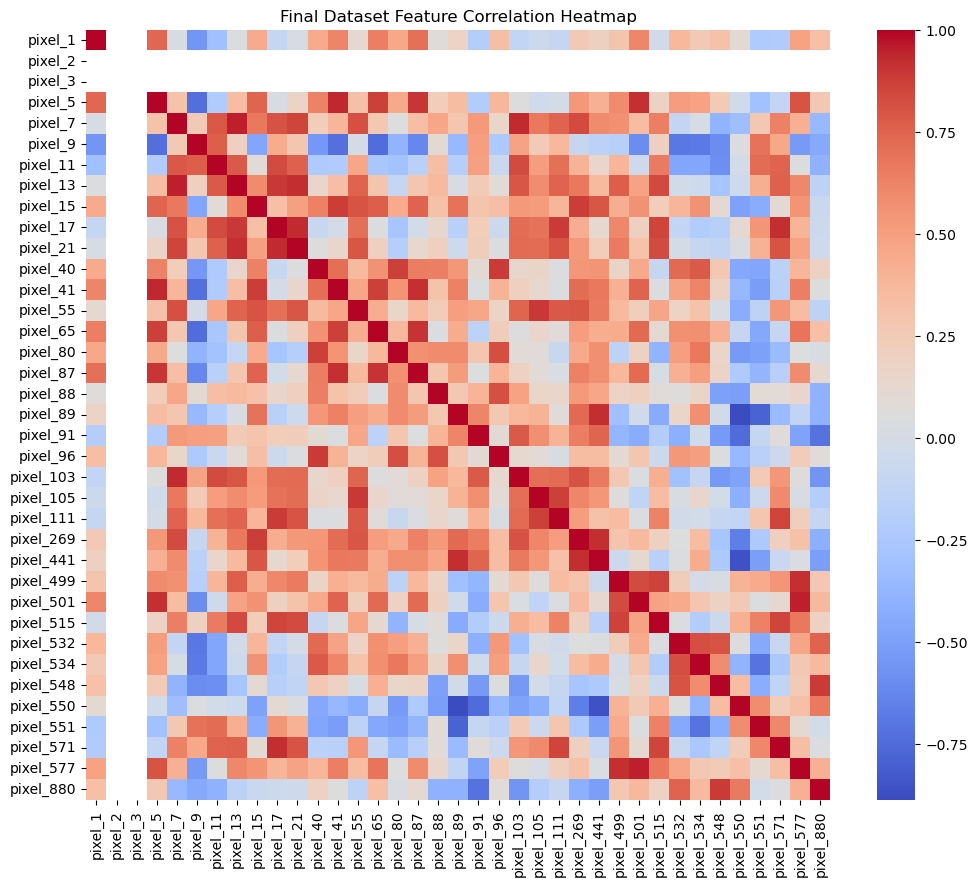

In [16]:
#df_kaggle heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
correlation_matrix = df_kaggle.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Final Dataset Feature Correlation Heatmap')
plt.show()

In [17]:
df_kaggle =df_kaggle.drop(columns=['pixel_2', 'pixel_3'])

df_kaggle['emotion'] = target_dummies.idxmax(axis=1).str.replace('target_', '')
print(df_kaggle.head())

    pixel_1   pixel_5   pixel_7   pixel_9  pixel_11  pixel_13  pixel_15  \
0  0.282565  0.077087 -0.256194 -0.083796 -0.190934 -0.442115 -0.375451   
1  0.294647  0.083331 -0.256183 -0.084780 -0.192047 -0.442747 -0.359947   
2  0.297403  0.084143 -0.253532 -0.084386 -0.190602 -0.438377 -0.361878   
3  0.306531  0.085495 -0.250795 -0.084024 -0.189034 -0.433570 -0.353412   
4  0.305434  0.085169 -0.250583 -0.083871 -0.188859 -0.433491 -0.353425   

   pixel_17  pixel_21  pixel_40  ...  pixel_515  pixel_532  pixel_534  \
0 -0.596181 -1.101262 -0.035559  ...  -0.658206   0.209742   0.079333   
1 -0.606139 -1.113812 -0.037741  ...  -0.648595   0.205951   0.068695   
2 -0.601759 -1.109217 -0.037865  ...  -0.644034   0.204116   0.066949   
3 -0.594336 -1.103871 -0.038186  ...  -0.638610   0.202202   0.055766   
4 -0.593841 -1.101853 -0.037892  ...  -0.640952   0.201771   0.055446   

   pixel_548  pixel_550  pixel_551  pixel_571  pixel_577  pixel_880  emotion  
0   0.035142   0.033892  -0.093

In [18]:

# --- PREPARATION ---
# 1. Create a helper dataframe to calculate correlations
df_calc = df_kaggle.copy()
df_calc['emotion_code'] = df_calc['emotion'].astype('category').cat.codes

# 2. Calculate correlations (ignoring the text column to avoid errors)
correlations = df_calc.corr(numeric_only=True)['emotion_code'].abs().drop('emotion_code')

# 3. Get the Top 2 Winners
best_feature = correlations.idxmax()
second_best_feature = correlations.sort_values(ascending=False).index[1]

print(f"🥇 Best Feature: '{best_feature}'")
print(f"🥈 2nd Best:    '{second_best_feature}'")

🥇 Best Feature: 'pixel_1'
🥈 2nd Best:    'pixel_15'


👑 The King Feature is: 'pixel_1'
   Correlation Strength: 0.226


C:\Users\PC\AppData\Local\Temp\ipykernel_19528\785329479.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='emotion', y=best_feature, data=df_kaggle, palette='coolwarm')


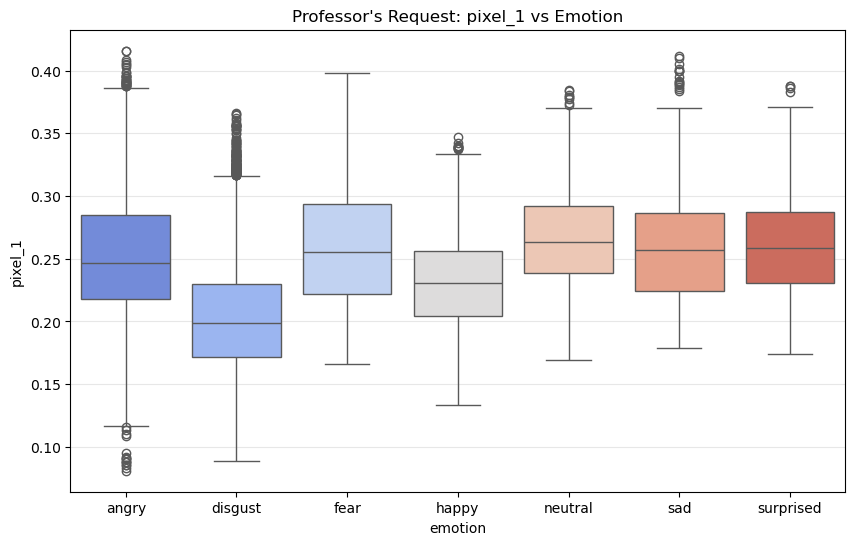

In [19]:
# 1. Setup the calculation dataframe
df_calc = df_kaggle.copy()
df_calc['emotion_code'] = df_calc['emotion'].astype('category').cat.codes

# 2. Calculate Correlation (FIXED: added numeric_only=True)
# This prevents it from trying to calculate "happy" * "sad"
correlations = df_calc.corr(numeric_only=True)['emotion_code'].abs().drop('emotion_code')

# 3. Find the Winner
best_feature = correlations.idxmax()
best_score = correlations.max()

print(f"👑 The King Feature is: '{best_feature}'")
print(f"   Correlation Strength: {best_score:.3f}")

# 4. PLOT IT (Box Plot is best for Feature vs Category)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='emotion', y=best_feature, data=df_kaggle, palette='coolwarm')
plt.title(f'Professor\'s Request: {best_feature} vs Emotion')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_19528\2166819762.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


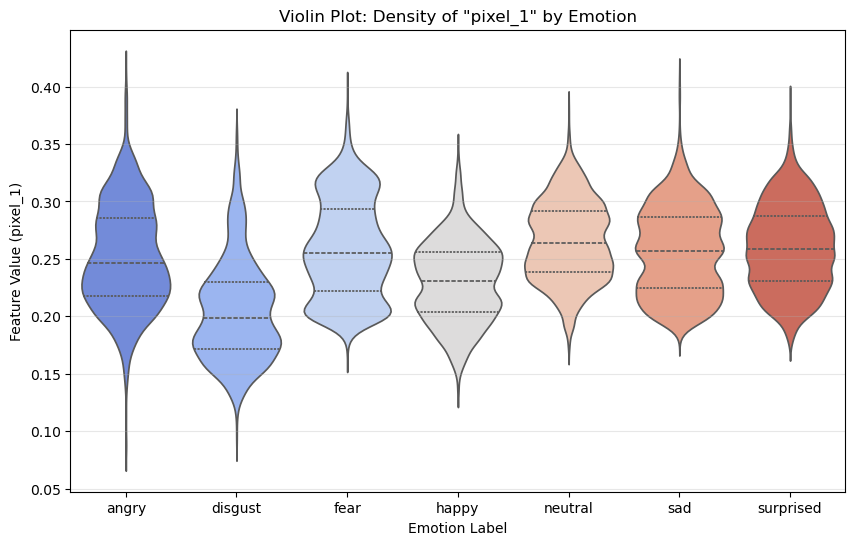

In [20]:
# --- VIOLIN PLOT ---
plt.figure(figsize=(10, 6))

sns.violinplot(
    x='emotion', 
    y=best_feature, 
    data=df_kaggle, 
    palette='coolwarm', 
    inner='quartile'  # Draws lines for the median and quartiles inside
)

plt.title(f'Violin Plot: Density of "{best_feature}" by Emotion')
plt.xlabel('Emotion Label')
plt.ylabel(f'Feature Value ({best_feature})')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

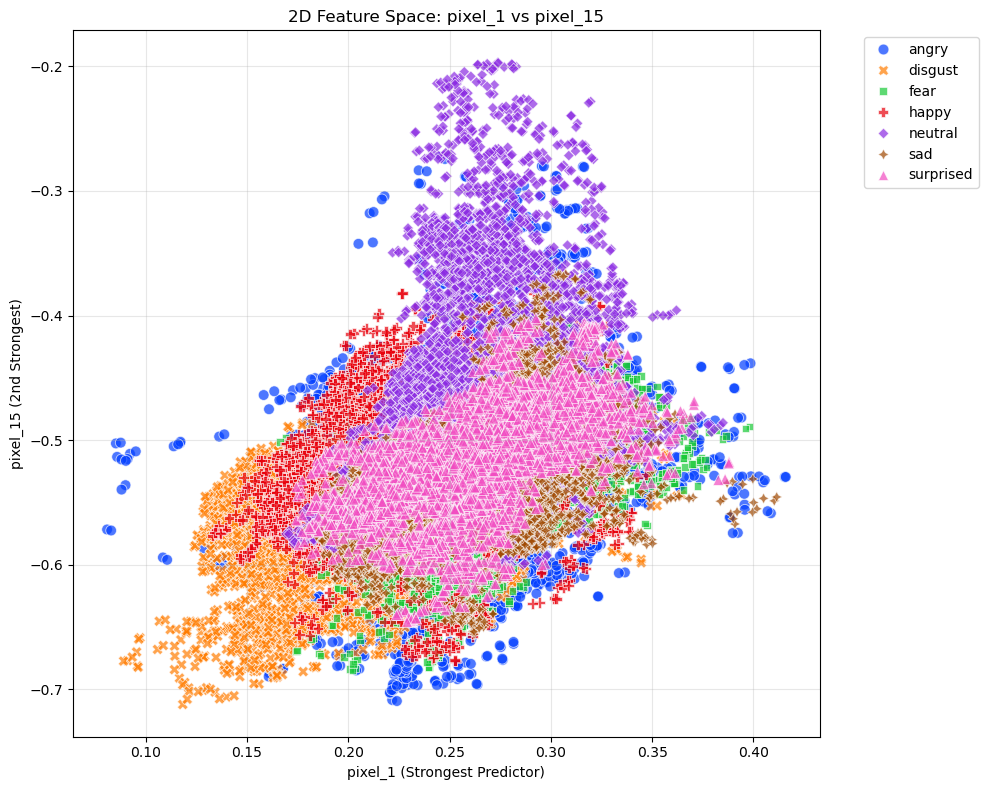

In [21]:
# --- 2D SCATTER PLOT ---
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=df_kaggle, 
    x=best_feature, 
    y=second_best_feature, 
    hue='emotion',      # Color dots by Emotion
    style='emotion',    # different shapes for different emotions (optional, helps accessibility)
    palette='bright',
    alpha=0.7,          # Make dots slightly transparent to see overlaps
    s=60                # Dot size
)

plt.title(f'2D Feature Space: {best_feature} vs {second_best_feature}')
plt.xlabel(f"{best_feature} (Strongest Predictor)")
plt.ylabel(f"{second_best_feature} (2nd Strongest)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside if it blocks data
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_19528\1578841931.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


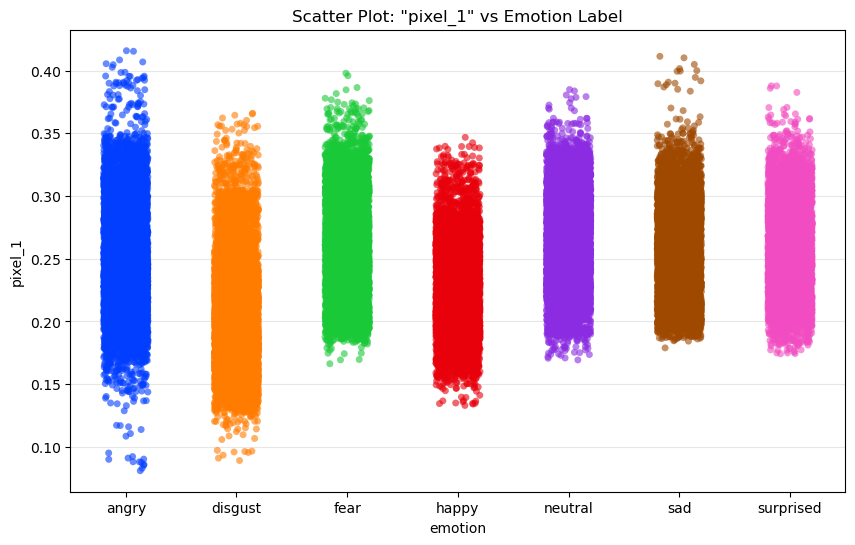

In [22]:
plt.figure(figsize=(10, 6))

# The 'jitter=True' is the magic that turns vertical lines into a scatter cloud
sns.stripplot(
    data=df_kaggle, 
    x='emotion', 
    y=best_feature, 
    palette='bright', 
    jitter=0.2,    # Spread the dots out horizontally
    alpha=0.6,     # Make them see-through so you can see density
    size=5         # Dot size
)

plt.title(f'Scatter Plot: "{best_feature}" vs Emotion Label')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# Audio Data Cleaning

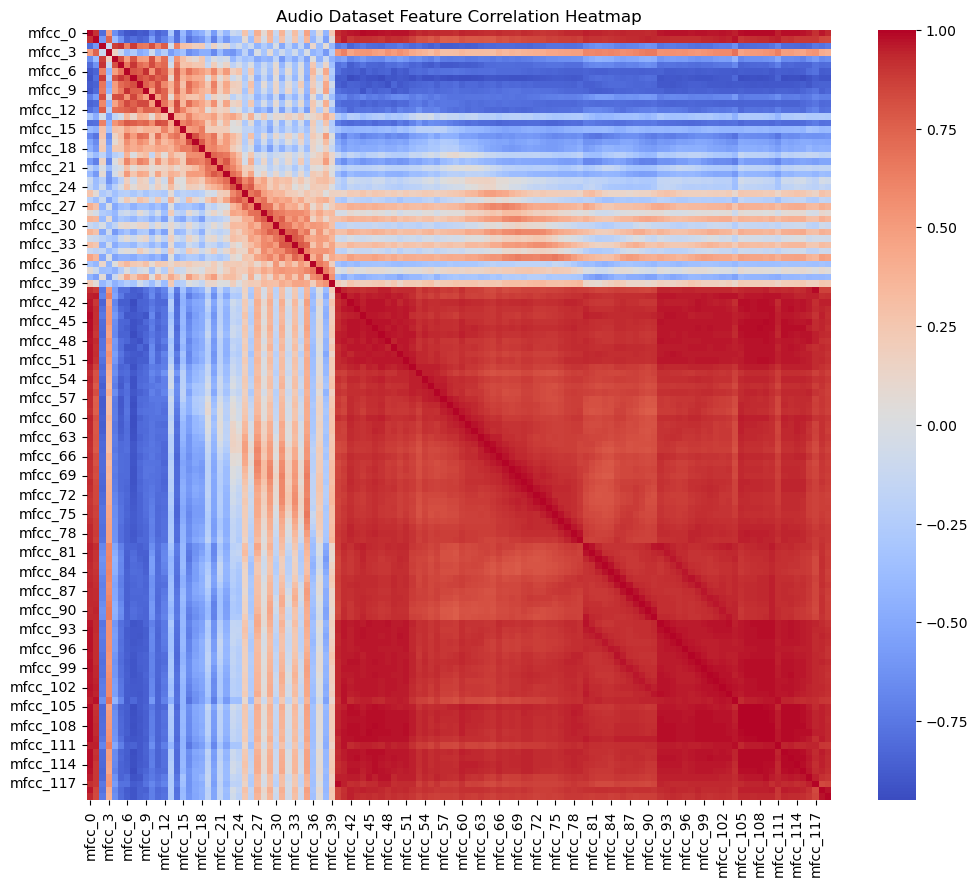

In [23]:
df_heatmap = df_Audio.drop(columns=['id', 'emotion'])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
correlation_matrix = df_heatmap.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Audio Dataset Feature Correlation Heatmap')
plt.show()

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 1. Create a copy so we don't mess up the original data
target_dummies = pd.get_dummies(df_Audio['emotion'], prefix='target')

df_Audio = df_Audio.drop(columns=['id', 'emotion'])

df_corr = pd.concat([df_Audio, target_dummies], axis=1)

corr_matrix = df_corr.corr()

feature_cols = df_Audio.columns
target_cols = target_dummies.columns

target_correlations = corr_matrix.loc[feature_cols, target_cols].abs()
max_audio_score = target_correlations.max(axis=1)

features_to_drop = max_audio_score[max_audio_score < 0.05 ].index.tolist()
print(f"Dropping {len(features_to_drop)} features with low correlation to targets.")

df_Audio = df_Audio.drop(columns=features_to_drop)

Dropping 82 features with low correlation to targets.


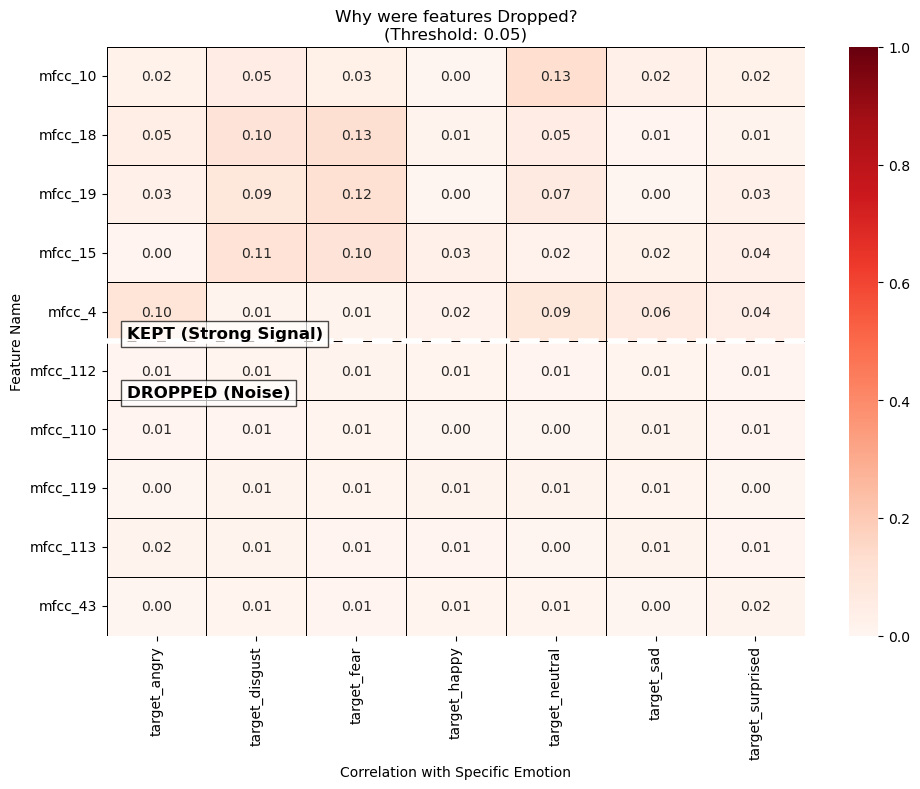

In [25]:
kept_features_audio = max_audio_score[max_audio_score >= 0.05].sort_values(ascending=False).head(5).index.tolist()
dropped_features_audio = max_audio_score[max_audio_score < 0.05].sort_values(ascending=True).head(5).index.tolist()
features_to_plot_audio = kept_features_audio + dropped_features_audio

plot_data_audio = target_correlations.loc[features_to_plot_audio]

plt.figure(figsize=(10, 8))
sns.heatmap(
        plot_data_audio, 
        annot=True,       # Show the numbers
        fmt=".2f",        # 2 decimal places
        cmap='Reds',  # Red = High, Blue = Low
        vmin=0, vmax=1,   # Scale from 0 to 1
        linewidths=0.5,
        linecolor='black'
    )

plt.axhline(len(kept_features_audio), color='white', linewidth=4, linestyle='--')
plt.text(0.2, len(kept_features_audio) - 0.05, "KEPT (Strong Signal)", color='black', fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
plt.text(0.2, len(kept_features_audio) + 0.95, "DROPPED (Noise)", color='black', fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))

plt.title(f"Why were features Dropped?\n(Threshold: {0.05})")
plt.xlabel("Correlation with Specific Emotion")
plt.ylabel("Feature Name")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
corr_matrix = df_Audio.corr().abs()

mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper = corr_matrix.where(mask)

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"✅ Dropped {len(to_drop)} redundant features.")
df_Audio = df_Audio.drop(columns=to_drop)

✅ Dropped 5 redundant features.


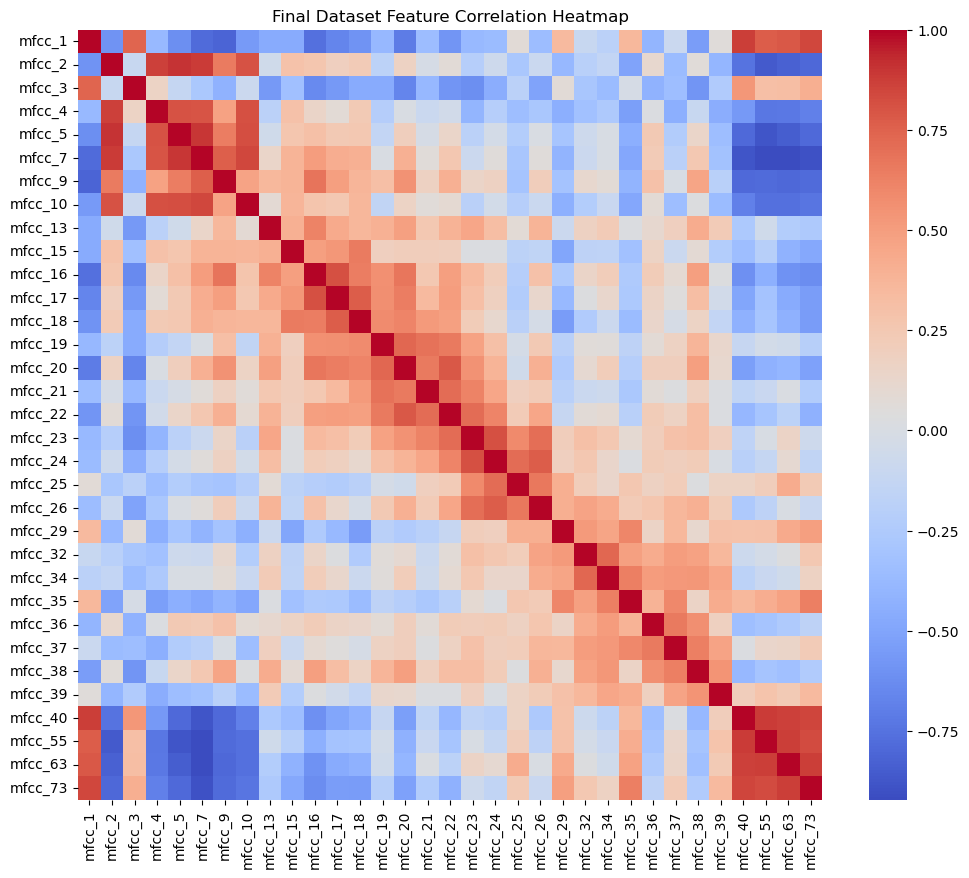

In [27]:
#df_Audio heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
correlation_matrix = df_Audio.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Final Dataset Feature Correlation Heatmap')
plt.show()

In [28]:
df_Audio['emotion'] = target_dummies.idxmax(axis=1).str.replace('target_', '')
print(df_Audio.head())

      mfcc_1     mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_7  \
0  75.259445  -6.759887  19.964931  -5.159092  -6.579600   0.228306   
1  70.724022 -22.633474   8.530368 -13.395951 -10.976827 -17.617781   
2  92.365135  10.084575  23.447985   3.723260  -8.903419  -8.851965   
3  59.885502 -20.256659   5.426655 -17.499435 -12.566243 -23.689978   
4  69.648979  -7.049018  16.514681 -10.613578  -7.778811 -11.818856   

      mfcc_9   mfcc_10    mfcc_13   mfcc_15  ...   mfcc_35   mfcc_36  \
0  -9.499395 -2.291525  -9.008268 -2.506961  ... -0.098962 -2.395944   
1  -5.542574 -5.865824   1.039081 -6.813544  ...  2.164737 -1.827856   
2  -5.692887 -4.348501  -2.792613 -1.220426  ... -0.084973 -5.085742   
3  -9.300064 -7.591999  -4.696489 -6.760776  ...  0.305808 -0.702044   
4 -13.354735 -8.868603 -10.547956 -5.134231  ...  2.854772 -0.050282   

    mfcc_37   mfcc_38   mfcc_39     mfcc_40   mfcc_55    mfcc_63    mfcc_73  \
0 -0.189819 -6.524618 -2.137166  142.544495  8.697461   7.424

# Train and Test Split

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

X=df_kaggle.drop(columns=['emotion'])
y=df_kaggle['emotion']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=df_kaggle['emotion']
)


In [30]:
X_audio=df_Audio.drop(columns=['emotion'])
y_audio=df_Audio['emotion']

scaler = StandardScaler()
X_scaled_audio = scaler.fit_transform(X_audio)

X_train_audio, X_test_audio, y_train_audio, y_test_audio = train_test_split(
    X_scaled_audio,
    y_audio,
    test_size=0.2,
    random_state=42,
    stratify=df_Audio['emotion']
)


# Decision Tree

🌳 Tuning Decision Tree Depth...
   Depth 1: Train=0.26, Test=0.26
   Depth 3: Train=0.34, Test=0.34
   Depth 5: Train=0.45, Test=0.44
   Depth 7: Train=0.55, Test=0.55
   Depth 10: Train=0.71, Test=0.69
   Depth 15: Train=0.89, Test=0.85
   Depth 20: Train=0.98, Test=0.92


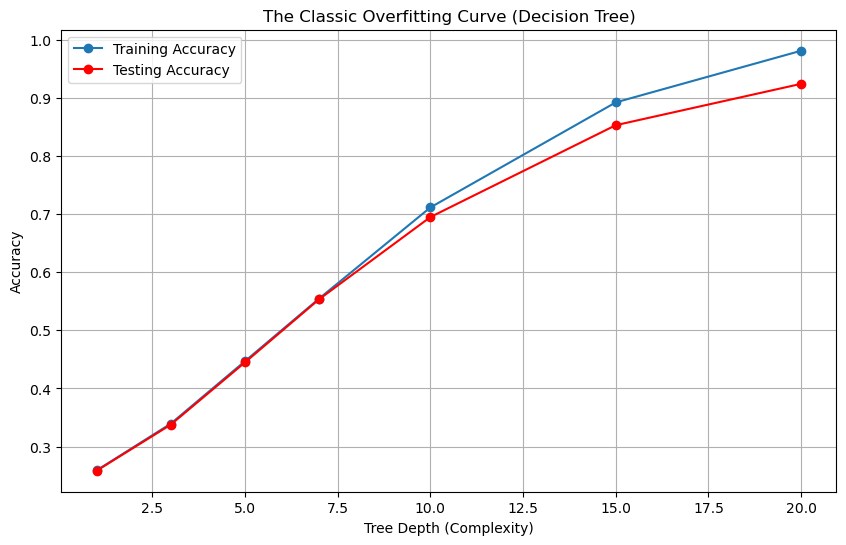

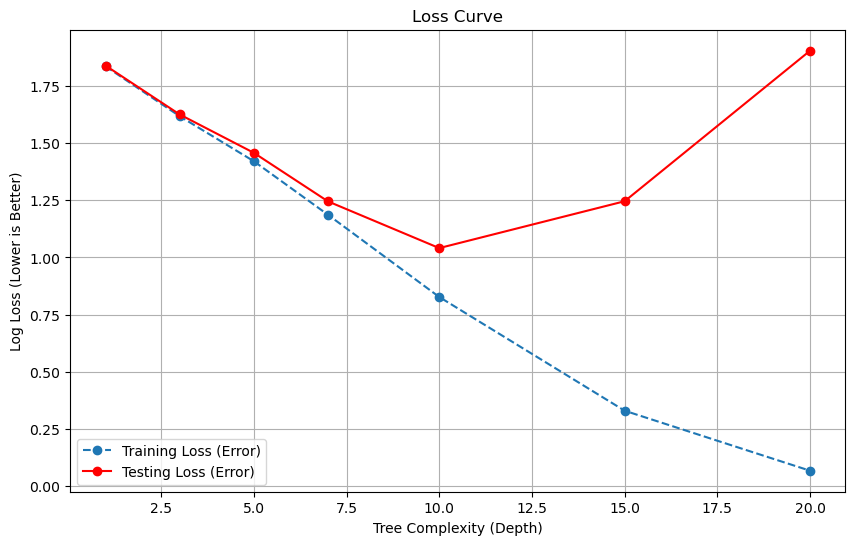

✅ Best Model Saved: best_tree_depth_20.pkl (Accuracy: 92.38%)


In [31]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# visualize loss
train_losses = []
test_losses = []
# Lists to store results
train_scores = []
test_scores = []
depths = [1, 3, 5, 7, 10, 15, 20]

print("🌳 Tuning Decision Tree Depth...")

best_acc = 0.0
best_model = None
best_depth = 0

for d in depths:
    # 1. Create Model with specific depth
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    
    # 2. Train
    clf.fit(X_train, y_train)
    
    # 3. Measure
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    
    y_train_probs = clf.predict_proba(X_train)
    y_test_probs = clf.predict_proba(X_test)

    loss_train = log_loss(y_train, y_train_probs)
    loss_test = log_loss(y_test, y_test_probs)

    train_losses.append(loss_train)
    test_losses.append(loss_test)

    train_scores.append(train_acc)
    test_scores.append(test_acc)
    
    print(f"   Depth {d}: Train={train_acc:.2f}, Test={test_acc:.2f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = clf
        best_depth = d

# 4. PLOT THE "OVERFITTING" CURVE
plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, label='Training Accuracy', marker='o')
plt.plot(depths, test_scores, label='Testing Accuracy', marker='o', color='red')
plt.title('The Classic Overfitting Curve (Decision Tree)')
plt.xlabel('Tree Depth (Complexity)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Loss Curve

plt.figure(figsize=(10, 6))
plt.plot(depths, train_losses, label='Training Loss (Error)', marker='o', linestyle='--')
plt.plot(depths, test_losses, label='Testing Loss (Error)', marker='o', color='red')
plt.title('Loss Curve')
plt.xlabel('Tree Complexity (Depth)')
plt.ylabel('Log Loss (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()

filename = f"best_tree_depth_{best_depth}.pkl"
joblib.dump(best_model, filename)
print(f"✅ Best Model Saved: {filename} (Accuracy: {best_acc:.2%})")

In [32]:
# train_losses = []
# test_losses = []
# # Lists to store results
# train_scores = []
# test_scores = []
# depths = [1, 3, 5, 7, 10, 15, 20, 30]

# best_acc = 0.0
# best_model = None
# best_depth = 0

# print("🌳 Tuning Decision Tree Depth...")

# for d in depths:
#     # 1. Create Model with specific depth
#     reg_tree = DecisionTreeClassifier(
#     max_depth= d, 
#     min_samples_leaf=10,  # <--- STRONG REGULARIZER
#     ccp_alpha=0.005,    # <--- PRUNING TO AVOID OVERFITTING
#     criterion='entropy',
#     random_state=42
# )
    
#     # 2. Train
#     reg_tree.fit(X_train, y_train)
    
#     # 3. Measure
#     train_acc = accuracy_score(y_train, reg_tree.predict(X_train))
#     test_acc = accuracy_score(y_test, reg_tree.predict(X_test))
    
#     y_train_probs = reg_tree.predict_proba(X_train)
#     y_test_probs = reg_tree.predict_proba(X_test)

#     loss_train = log_loss(y_train, y_train_probs)
#     loss_test = log_loss(y_test, y_test_probs)

#     train_losses.append(loss_train)
#     test_losses.append(loss_test)

#     train_scores.append(train_acc)
#     test_scores.append(test_acc)
    
#     print(f"   Depth {d}: Train={train_acc:.2f}, Test={test_acc:.2f}")

#     if test_acc > best_acc:
#         best_acc = test_acc
#         best_model = clf
#         best_depth = d

# # 4. PLOT THE "OVERFITTING" CURVE
# plt.figure(figsize=(10, 6))
# plt.plot(depths, train_scores, label='Training Accuracy', marker='o')
# plt.plot(depths, test_scores, label='Testing Accuracy', marker='o', color='red')
# plt.title('The Classic Overfitting Curve (Decision Tree)')
# plt.xlabel('Tree Depth (Complexity)')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plotting Loss Curve

# plt.figure(figsize=(10, 6))
# plt.plot(depths, train_losses, label='Training Loss (Error)', marker='o', linestyle='--')
# plt.plot(depths, test_losses, label='Testing Loss (Error)', marker='o', color='red')
# plt.title('Loss Curve')
# plt.xlabel('Tree Complexity (Depth)')
# plt.ylabel('Log Loss (Lower is Better)')
# plt.legend()
# plt.grid(True)
# plt.show()

# if best_model is not None:
#     filename = f"best_reg_tree_depth_{best_depth}.pkl"
#     joblib.dump(best_model, filename)
#     print(f"✅ Best Model Saved: {filename} (Accuracy: {best_acc:.2%})")

🌳 Tuning Decision Tree Depth...
   Depth 1: Train=0.21, Test=0.19
   Depth 3: Train=0.26, Test=0.21
   Depth 5: Train=0.30, Test=0.21
   Depth 7: Train=0.35, Test=0.21
   Depth 10: Train=0.37, Test=0.22
   Depth 15: Train=0.37, Test=0.21
   Depth 20: Train=0.37, Test=0.21


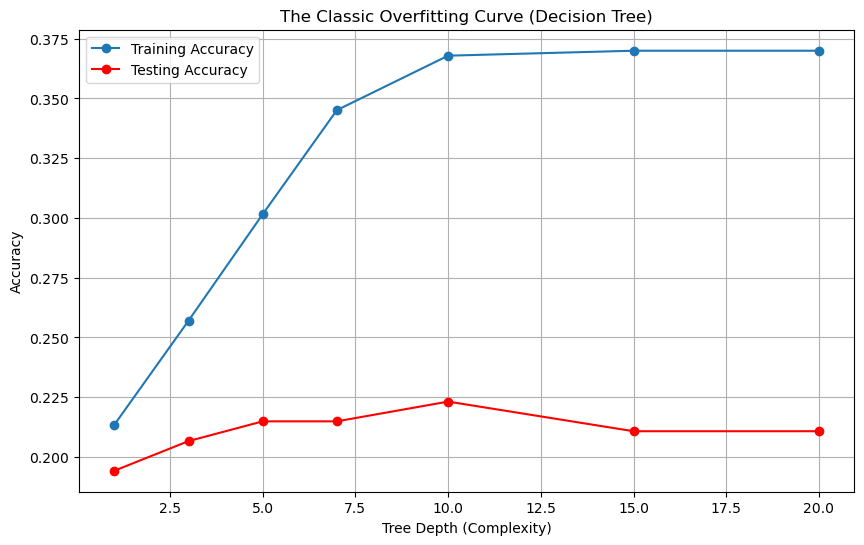

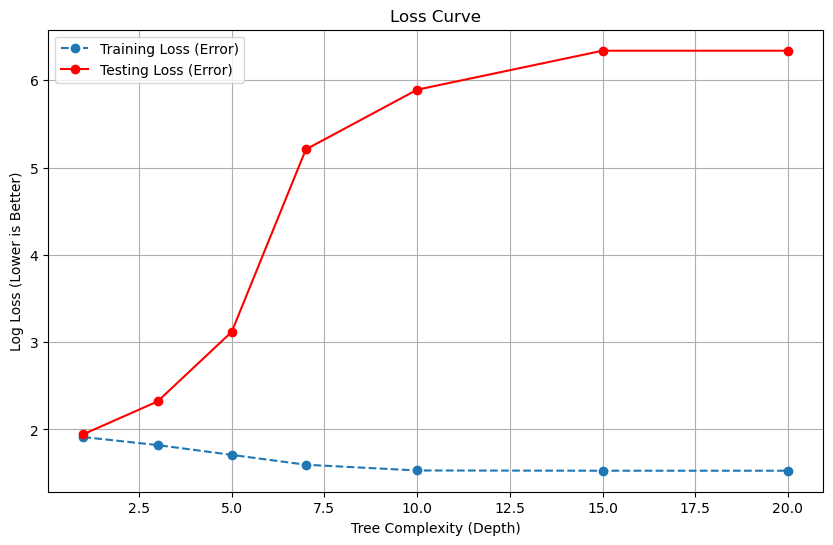

✅ Best Model Saved: best_tree_depth_1_audio.pkl (Accuracy: 92.38%)


In [33]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# visualize loss
train_losses_audio = []
test_losses_audio = []
# Lists to store results
train_scores_audio = []
test_scores_audio = []
depths_audio = [1, 3, 5, 7, 10, 15, 20]

best_acc = 0.0
best_model = None
best_depth = 0

print("🌳 Tuning Decision Tree Depth...")

for d in depths_audio:
    # 1. Create Model with specific depth
    clf_audio = DecisionTreeClassifier(max_depth=d, random_state=42)
    
    # 2. Train
    clf_audio.fit(X_train_audio, y_train_audio)
    
    # 3. Measure
    train_acc_audio = accuracy_score(y_train_audio, clf_audio.predict(X_train_audio))
    test_acc_audio = accuracy_score(y_test_audio, clf_audio.predict(X_test_audio))
    
    y_train_audio_probs = clf_audio.predict_proba(X_train_audio)
    y_test_probs_audio = clf_audio.predict_proba(X_test_audio)

    loss_train_audio = log_loss(y_train_audio, y_train_audio_probs)
    loss_test_audio = log_loss(y_test_audio, y_test_probs_audio)

    train_losses_audio.append(loss_train_audio)
    test_losses_audio.append(loss_test_audio)

    train_scores_audio.append(train_acc_audio)
    test_scores_audio.append(test_acc_audio)
    
    print(f"   Depth {d}: Train={train_acc_audio:.2f}, Test={test_acc_audio:.2f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = clf
        best_depth = d

# 4. PLOT THE "OVERFITTING" CURVE
plt.figure(figsize=(10, 6))
plt.plot(depths_audio, train_scores_audio, label='Training Accuracy', marker='o')
plt.plot(depths_audio, test_scores_audio, label='Testing Accuracy', marker='o', color='red')
plt.title('The Classic Overfitting Curve (Decision Tree)')
plt.xlabel('Tree Depth (Complexity)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Loss Curve

plt.figure(figsize=(10, 6))
plt.plot(depths_audio, train_losses_audio, label='Training Loss (Error)', marker='o', linestyle='--')
plt.plot(depths_audio, test_losses_audio, label='Testing Loss (Error)', marker='o', color='red')
plt.title('Loss Curve')
plt.xlabel('Tree Complexity (Depth)')
plt.ylabel('Log Loss (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()

if best_model is not None:
    filename = f"best_tree_depth_{best_depth}_audio.pkl"
    joblib.dump(best_model, filename)
    print(f"✅ Best Model Saved: {filename} (Accuracy: {best_acc:.2%})")

In [34]:



# train_losses_audio = []
# test_losses_audio = []
# # Lists to store results
# train_scores_audio = []
# test_scores_audio = []
# depths_audio = [1, 3, 5, 7, 10, 15, 20, 30]

# best_acc = 0.0
# best_model = None
# best_depth = 0

# print("🌳 Tuning Decision Tree Depth...")

# for d in depths_audio:
#     # 1. Create Model with specific depth
#     reg_tree_audio = DecisionTreeClassifier(
#     max_depth= d, 
#     min_samples_leaf=10,  # <--- STRONG REGULARIZER
#     ccp_alpha=0.05,    # <--- PRUNING TO AVOID OVERFITTING
#     criterion='entropy',
#     random_state=42
# )
    
#     # 2. Train
#     reg_tree_audio.fit(X_train_audio, y_train_audio)
    
#     # 3. Measure
#     train_acc_audio = accuracy_score(y_train_audio, reg_tree_audio.predict(X_train_audio))
#     test_acc_audio = accuracy_score(y_test_audio, reg_tree_audio.predict(X_test_audio))
    
#     y_train_probs_audio = reg_tree_audio.predict_proba(X_train_audio)
#     y_test_probs_audio = reg_tree_audio.predict_proba(X_test_audio)

#     loss_train_audio = log_loss(y_train_audio, y_train_probs_audio)
#     loss_test_audio = log_loss(y_test_audio, y_test_probs_audio)

#     train_losses_audio.append(loss_train_audio)
#     test_losses_audio.append(loss_test_audio)

#     train_scores_audio.append(train_acc_audio)
#     test_scores_audio.append(test_acc_audio)
    
#     print(f"   Depth {d}: Train={train_acc_audio:.2f}, Test={test_acc_audio:.2f}")

#     if test_acc > best_acc:
#         best_acc = test_acc
#         best_model = clf
#         best_depth = d

# # 4. PLOT THE "OVERFITTING" CURVE
# plt.figure(figsize=(10, 6))
# plt.plot(depths_audio, train_scores_audio, label='Training Accuracy', marker='o')
# plt.plot(depths_audio, test_scores_audio, label='Testing Accuracy', marker='o', color='red')
# plt.title('The Classic Overfitting Curve (Decision Tree)')
# plt.xlabel('Tree Depth (Complexity)')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plotting Loss Curve

# plt.figure(figsize=(10, 6))
# plt.plot(depths_audio, train_losses_audio, label='Training Loss (Error)', marker='o', linestyle='--')
# plt.plot(depths_audio, test_losses_audio, label='Testing Loss (Error)', marker='o', color='red')
# plt.title('Loss Curve')
# plt.xlabel('Tree Complexity (Depth)')
# plt.ylabel('Log Loss (Lower is Better)')
# plt.legend()
# plt.grid(True)
# plt.show()

# if best_model is not None:
#     filename = f"best_reg_tree_depth_{best_depth}_audio.pkl"
#     joblib.dump(best_model, filename)
#     print(f"✅ Best Model Saved: {filename} (Accuracy: {best_acc:.2%})")

# KNN

🏷️ Class Mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
   (Note: Check which number 'Angry' is. You might need this for your App!)

📍 Tuning Normal KNN (Video)...
   k=1: Train Acc=1.00 | Test Acc=1.00 | Test Loss=0.09
   k=3: Train Acc=1.00 | Test Acc=1.00 | Test Loss=0.06
   k=5: Train Acc=1.00 | Test Acc=1.00 | Test Loss=0.04
   k=7: Train Acc=1.00 | Test Acc=0.99 | Test Loss=0.04
   k=10: Train Acc=1.00 | Test Acc=0.99 | Test Loss=0.05
   k=15: Train Acc=1.00 | Test Acc=0.99 | Test Loss=0.06
   k=20: Train Acc=1.00 | Test Acc=0.98 | Test Loss=0.08


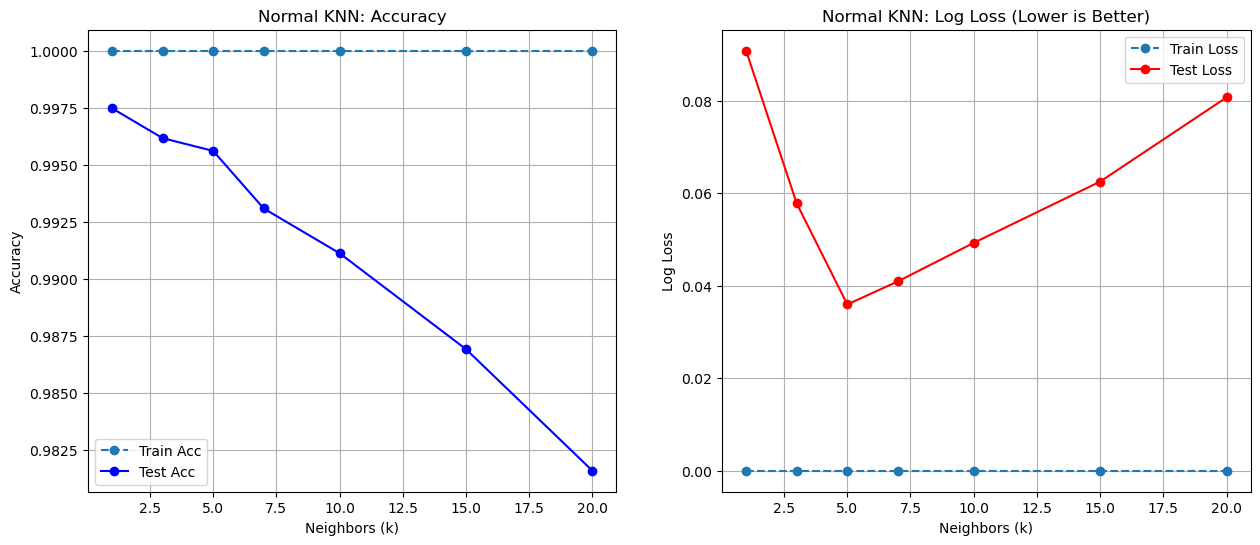

✅ Best Normal k: 1


['knn_emotion_video_normal.pkl']

In [35]:

from sklearn.neighbors import KNeighborsClassifier


# --- 1. DATA FIX: ENCODE LABELS ---
# This converts 'angry', 'neutral' -> 0, 1 to prevent the ValueError
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("🏷️ Class Mapping:", dict(zip(le.classes_, range(len(le.classes_)))))
print("   (Note: Check which number 'Angry' is. You might need this for your App!)")

# --- 2. SETUP ---
neighbors = [1, 3, 5, 7, 10, 15, 20]

# Global lists to store results for Cell 2
global test_acc_normal, test_loss_normal
train_acc_normal, test_acc_normal = [], []
train_loss_normal, test_loss_normal = [], []

print("\n📍 Tuning Normal KNN (Video)...")

for k in neighbors:
    # NORMAL MODEL: Distance weights + Euclidean
    clf = KNeighborsClassifier(n_neighbors=k, weights='distance', p=2, n_jobs=-1)
    clf.fit(X_train, y_train_enc)
    
    # Calculate Probabilities for Log Loss
    y_probs_train = clf.predict_proba(X_train)
    y_probs_test = clf.predict_proba(X_test)
    
    # Store Metrics
    train_acc_normal.append(accuracy_score(y_train_enc, clf.predict(X_train)))
    test_acc_normal.append(accuracy_score(y_test_enc, clf.predict(X_test)))
    
    train_loss_normal.append(log_loss(y_train_enc, y_probs_train))
    test_loss_normal.append(log_loss(y_test_enc, y_probs_test))
    
    print(f"   k={k}: Train Acc={train_acc_normal[-1]:.2f} | Test Acc={test_acc_normal[-1]:.2f} | Test Loss={test_loss_normal[-1]:.2f}")

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy Plot
ax1.plot(neighbors, train_acc_normal, label='Train Acc', marker='o', linestyle='--')
ax1.plot(neighbors, test_acc_normal, label='Test Acc', marker='o', color='blue')
ax1.set_title('Normal KNN: Accuracy')
ax1.set_xlabel('Neighbors (k)')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss Plot
ax2.plot(neighbors, train_loss_normal, label='Train Loss', marker='o', linestyle='--')
ax2.plot(neighbors, test_loss_normal, label='Test Loss', marker='o', color='red')
ax2.set_title('Normal KNN: Log Loss (Lower is Better)')
ax2.set_xlabel('Neighbors (k)')
ax2.set_ylabel('Log Loss')
ax2.legend()
ax2.grid(True)

plt.show()

# Save Best Normal Model
best_idx = np.argmax(test_acc_normal)
print(f"✅ Best Normal k: {neighbors[best_idx]}")

# Save the encoder too, so we can decode '0' back to 'angry' later
joblib.dump(le, 'label_encoder.pkl') 

# Train and save best model
best_normal = KNeighborsClassifier(n_neighbors=neighbors[best_idx], weights='distance', n_jobs=-1)
best_normal.fit(X_train, y_train_enc)
joblib.dump(best_normal, 'knn_emotion_video_normal.pkl')

In [36]:
# # Check if Cell 1 was run
# if 'test_loss_normal' not in globals():
#     print("⚠️ STOP: Run Cell 1 first to define the data and normal scores!")
# else:
#     train_acc_robust = []
#     train_loss_robust = [] 
#     test_acc_robust = []
#     test_loss_robust = []
    
#     print("🛡️ Tuning Robust KNN (Video)...")

#     for k in neighbors:
#         # ROBUST MODEL: Uniform weights + Manhattan
#         # We use y_train_enc to avoid the ValueError
#         clf = KNeighborsClassifier(n_neighbors=k, weights='uniform', p=1, n_jobs=-1)
#         clf.fit(X_train, y_train_enc)
        
#         y_probs_test = clf.predict_proba(X_test)
        
#         # Store metrics
#         train_acc_robust.append(accuracy_score(y_train_enc, clf.predict(X_train)))
#         train_loss_robust.append(log_loss(y_train_enc, clf.predict_proba(X_train)))
#         test_acc_robust.append(accuracy_score(y_test_enc, clf.predict(X_test)))
#         test_loss_robust.append(log_loss(y_test_enc, y_probs_test))
        
#         # --- NEW: PRINT THE RESULTS ---
#         print(f"   k={k}: Train Acc={train_acc_robust[-1]:.2f} | Test Acc={test_acc_robust[-1]:.2f} | Test Loss={test_loss_robust[-1]:.2f}")

#     # --- COMPARISON PLOTS ---
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

#     # 1. ACCURACY COMPARISON
#     ax1.plot(neighbors, test_acc_normal, label='Normal (Distance)', marker='o', color='blue', alpha=0.5)
#     ax1.plot(neighbors, test_acc_robust, label='Robust (Uniform)', marker='s', color='green', linewidth=2)
#     ax1.plot(neighbors, train_acc_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
#     ax1.set_title('Accuracy: Normal vs Robust')
#     ax1.set_xlabel('Neighbors (k)')
#     ax1.set_ylabel('Test Accuracy')
#     ax1.legend()
#     ax1.grid(True)

#     # 2. LOSS COMPARISON
#     ax2.plot(neighbors, test_loss_normal, label='Normal (Distance)', marker='o', color='blue', alpha=0.5)
#     ax2.plot(neighbors, test_loss_robust, label='Robust (Uniform)', marker='s', color='green', linewidth=2)
#     ax2.plot(neighbors, train_loss_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
#     ax2.set_title('Log Loss: Normal vs Robust (Lower is Better)')
#     ax2.set_xlabel('Neighbors (k)')
#     ax2.set_ylabel('Log Loss')
#     ax2.legend()
#     ax2.grid(True)

#     plt.show()

#     # Save Best Robust Model
#     best_idx_r = np.argmax(test_acc_robust)
#     print(f"✅ Best Robust k: {neighbors[best_idx_r]}")
    
#     final_robust_model = KNeighborsClassifier(n_neighbors=neighbors[best_idx_r], weights='uniform', p=1, n_jobs=-1)
#     final_robust_model.fit(X_train, y_train_enc)
#     joblib.dump(final_robust_model, 'knn_emotion_model.pkl')
#     print("💾 Saved final model as 'knn_emotion_model.pkl'")

🎤 Audio Class Mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}

📍 Tuning Normal KNN (Audio)...
   k=1: Train Acc=0.31 | Test Acc=0.24 | Test Loss=27.55
   k=3: Train Acc=0.32 | Test Acc=0.25 | Test Loss=19.20
   k=5: Train Acc=0.30 | Test Acc=0.19 | Test Loss=15.93
   k=7: Train Acc=0.30 | Test Acc=0.19 | Test Loss=11.98
   k=10: Train Acc=0.31 | Test Acc=0.21 | Test Loss=6.64
   k=15: Train Acc=0.31 | Test Acc=0.20 | Test Loss=2.03
   k=20: Train Acc=0.32 | Test Acc=0.21 | Test Loss=1.93


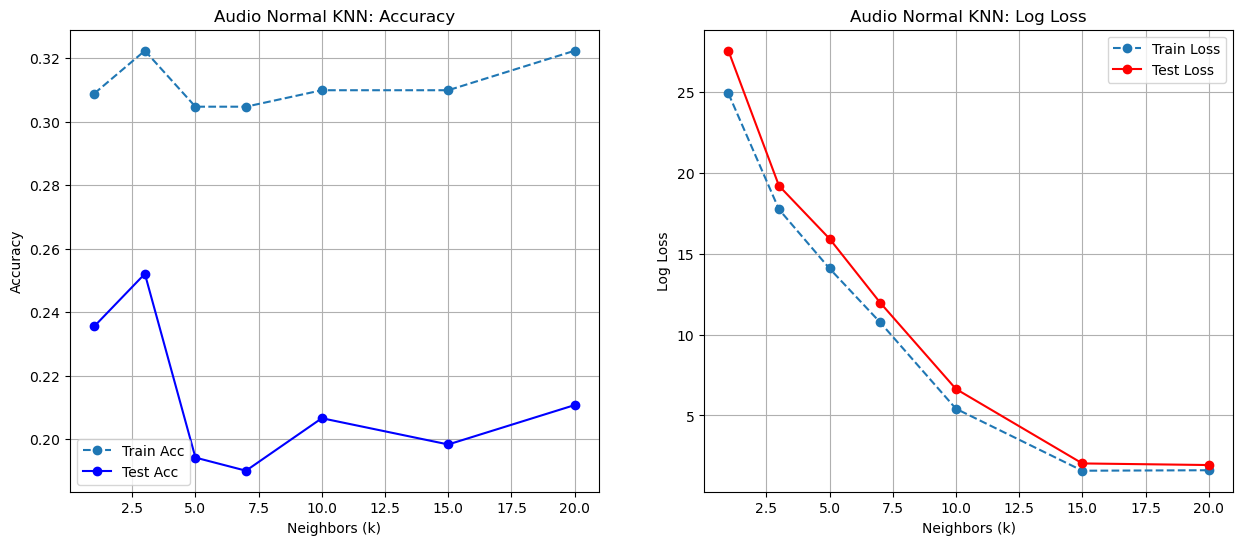

✅ Best Normal Audio k: 3


['knn_emotion_audio_normal.pkl']

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder

# --- 1. DATA FIX: ENCODE AUDIO LABELS ---
# We use a separate encoder for audio just in case the labels differ slightly
le_audio = LabelEncoder()
y_train_audio_enc = le_audio.fit_transform(y_train_audio)
y_test_audio_enc = le_audio.transform(y_test_audio)

print("🎤 Audio Class Mapping:", dict(zip(le_audio.classes_, range(len(le_audio.classes_)))))

# --- 2. SETUP ---
# Audio often needs slightly larger 'k' to smooth out noise
neighbors_audio = [1, 3, 5, 7, 10, 15, 20]

# Global lists for Cell 2
global test_acc_audio_normal, test_loss_audio_normal
train_acc_audio_normal, test_acc_audio_normal = [], []
train_loss_audio_normal, test_loss_audio_normal = [], []

print("\n📍 Tuning Normal KNN (Audio)...")

for k in neighbors_audio:
    # NORMAL MODEL: Distance weights + Euclidean
    clf = KNeighborsClassifier(n_neighbors=k, weights='distance', p=2, n_jobs=-1)
    clf.fit(X_train_audio, y_train_audio_enc)
    
    # Calculate Probabilities
    y_probs_train = clf.predict_proba(X_train_audio)
    y_probs_test = clf.predict_proba(X_test_audio)
    
    # Store Metrics
    train_acc_audio_normal.append(accuracy_score(y_train_audio_enc, clf.predict(X_train_audio)))
    test_acc_audio_normal.append(accuracy_score(y_test_audio_enc, clf.predict(X_test_audio)))
    
    train_loss_audio_normal.append(log_loss(y_train_audio_enc, y_probs_train))
    test_loss_audio_normal.append(log_loss(y_test_audio_enc, y_probs_test))
    
    print(f"   k={k}: Train Acc={train_acc_audio_normal[-1]:.2f} | Test Acc={test_acc_audio_normal[-1]:.2f} | Test Loss={test_loss_audio_normal[-1]:.2f}")

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy Plot
ax1.plot(neighbors_audio, train_acc_audio_normal, label='Train Acc', marker='o', linestyle='--')
ax1.plot(neighbors_audio, test_acc_audio_normal, label='Test Acc', marker='o', color='blue')
ax1.set_title('Audio Normal KNN: Accuracy')
ax1.set_xlabel('Neighbors (k)')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss Plot
ax2.plot(neighbors_audio, train_loss_audio_normal, label='Train Loss', marker='o', linestyle='--')
ax2.plot(neighbors_audio, test_loss_audio_normal, label='Test Loss', marker='o', color='red')
ax2.set_title('Audio Normal KNN: Log Loss')
ax2.set_xlabel('Neighbors (k)')
ax2.set_ylabel('Log Loss')
ax2.legend()
ax2.grid(True)

plt.show()

# Save Best Normal Model & Encoder
best_idx_a = np.argmax(test_acc_audio_normal)
print(f"✅ Best Normal Audio k: {neighbors_audio[best_idx_a]}")

joblib.dump(le_audio, 'label_encoder_audio.pkl') 

best_audio_normal = KNeighborsClassifier(n_neighbors=neighbors_audio[best_idx_a], weights='distance', n_jobs=-1)
best_audio_normal.fit(X_train_audio, y_train_audio_enc)
joblib.dump(best_audio_normal, 'knn_emotion_audio_normal.pkl')

In [38]:
# if 'test_loss_audio_normal' not in globals():
#     print("⚠️ STOP: Run Audio Cell 1 first!")
# else:
#     train_acc_audio_robust = []
#     test_acc_audio_robust = []
#     test_loss_audio_robust = []
    
#     print("🛡️ Tuning Robust KNN (Audio)...")

#     for k in neighbors_audio:
#         # ROBUST MODEL: Uniform weights + Manhattan
#         # Using encoded labels
#         clf = KNeighborsClassifier(n_neighbors=k, weights='uniform', p=1, n_jobs=-1)
#         clf.fit(X_train_audio, y_train_audio_enc)
        
#         y_probs_test = clf.predict_proba(X_test_audio)
        
#         # Store metrics
#         train_acc_audio_robust.append(accuracy_score(y_train_audio_enc, clf.predict(X_train_audio)))
#         test_acc_audio_robust.append(accuracy_score(y_test_audio_enc, clf.predict(X_test_audio)))
#         test_loss_audio_robust.append(log_loss(y_test_audio_enc, y_probs_test))
        
#         # --- PRINT THE RESULTS ---
#         print(f"   k={k}: Train Acc={train_acc_audio_robust[-1]:.2f} | Test Acc={test_acc_audio_robust[-1]:.2f} | Test Loss={test_loss_audio_robust[-1]:.2f}")

#     # --- COMPARISON PLOTS ---
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

#     # 1. ACCURACY COMPARISON
#     ax1.plot(neighbors_audio, train_acc_audio_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
#     ax1.plot(neighbors_audio, test_acc_audio_normal, label='Normal (Distance)', marker='o', color='blue', alpha=0.5)
#     ax1.plot(neighbors_audio, test_acc_audio_robust, label='Robust (Uniform)', marker='s', color='green', linewidth=2)
#     ax1.set_title('Audio Accuracy: Normal vs Robust')
#     ax1.set_xlabel('Neighbors (k)')
#     ax1.set_ylabel('Test Accuracy')
#     ax1.legend()
#     ax1.grid(True)

#     # 2. LOSS COMPARISON
#     ax2.plot(neighbors_audio, train_acc_audio_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
#     ax2.plot(neighbors_audio, test_loss_audio_normal, label='Normal (Distance)', marker='o', color='blue', alpha=0.5)
#     ax2.plot(neighbors_audio, test_loss_audio_robust, label='Robust (Uniform)', marker='s', color='green', linewidth=2)
#     ax2.set_title('Audio Log Loss: Normal vs Robust')
#     ax2.set_xlabel('Neighbors (k)')
#     ax2.set_ylabel('Log Loss')
#     ax2.legend()
#     ax2.grid(True)

#     plt.show()

#     # Save Best Robust Model
#     best_idx_ar = np.argmax(test_acc_audio_robust)
#     print(f"✅ Best Robust Audio k: {neighbors_audio[best_idx_ar]}")
    
#     final_robust_audio = KNeighborsClassifier(n_neighbors=neighbors_audio[best_idx_ar], weights='uniform', p=1, n_jobs=-1)
#     final_robust_audio.fit(X_train_audio, y_train_audio_enc)
#     joblib.dump(final_robust_audio, 'knn_emotion_audio_model.pkl')
#     print("💾 Saved final audio model as 'knn_emotion_audio_model.pkl'")

# SVM

📍 Tuning SVM C-Value (Video)...
   C=1: Train Acc=0.94 | Test Acc=0.94 | Test Loss=0.19


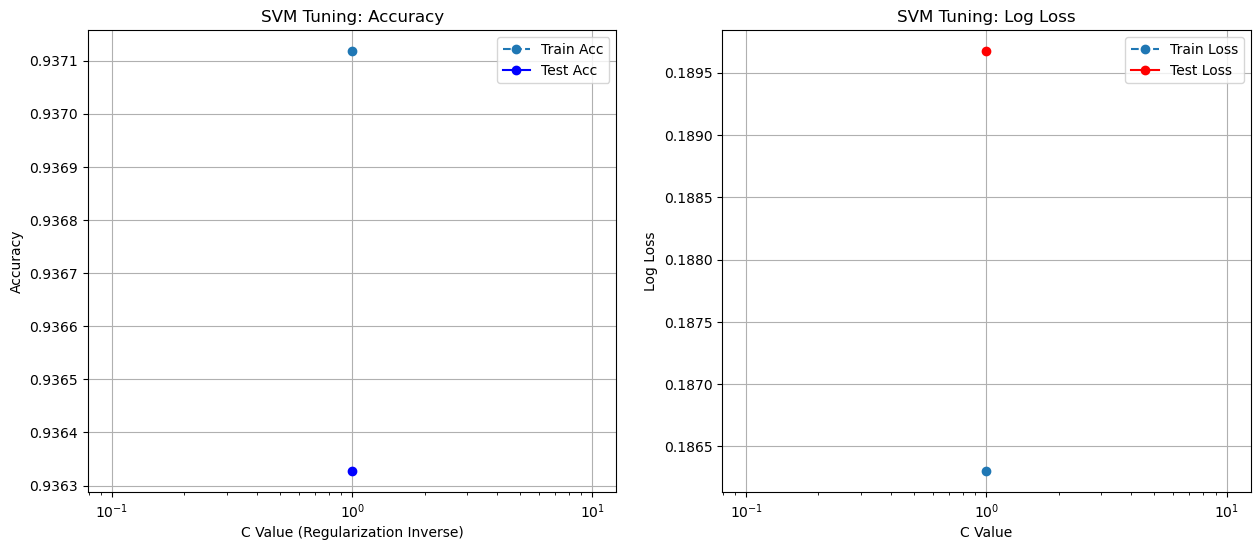

✅ Best SVM C: 1
💾 Saved as 'svm_emotion_video_model.pkl'


In [39]:

from sklearn.svm import SVC


# --- CONFIG ---
# C values are usually logarithmic (powers of 10)
c_values = [1]

# Global lists to store results for Cell 2
global test_acc_svm_normal, test_loss_svm_normal, train_acc_svm_normal
train_acc_svm_normal, test_acc_svm_normal = [], []
train_loss_svm_normal, test_loss_svm_normal = [], []

print("📍 Tuning SVM C-Value (Video)...")

for c in c_values:
    # 1. Create Model 
    # kernel='rbf' is standard for complex data like faces
    # probability=True is REQUIRED for log_loss and the live app
    clf = SVC(C=c, kernel='rbf', gamma='scale', probability=True, random_state=42)
    
    # 2. Train
    clf.fit(X_train, y_train)
    
    # 3. Measure
    # Predictions
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_probs_train = clf.predict_proba(X_train)
    y_probs_test = clf.predict_proba(X_test)
    
    # Store Metrics
    train_acc_svm_normal.append(accuracy_score(y_train, y_pred_train))
    test_acc_svm_normal.append(accuracy_score(y_test, y_pred_test))
    
    train_loss_svm_normal.append(log_loss(y_train, y_probs_train))
    test_loss_svm_normal.append(log_loss(y_test, y_probs_test))
    
    print(f"   C={c}: Train Acc={train_acc_svm_normal[-1]:.2f} | Test Acc={test_acc_svm_normal[-1]:.2f} | Test Loss={test_loss_svm_normal[-1]:.2f}")

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy Plot
ax1.plot(c_values, train_acc_svm_normal, label='Train Acc', marker='o', linestyle='--')
ax1.plot(c_values, test_acc_svm_normal, label='Test Acc', marker='o', color='blue')
ax1.set_xscale('log') # Log scale for C
ax1.set_title('SVM Tuning: Accuracy')
ax1.set_xlabel('C Value (Regularization Inverse)')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(c_values, train_loss_svm_normal, label='Train Loss', marker='o', linestyle='--')
ax2.plot(c_values, test_loss_svm_normal, label='Test Loss', marker='o', color='red')
ax2.set_xscale('log')
ax2.set_title('SVM Tuning: Log Loss')
ax2.set_xlabel('C Value')
ax2.set_ylabel('Log Loss')
ax2.legend()
ax2.grid(True)
plt.show()

best_idx = np.argmax(test_acc_svm_normal)
best_c = c_values[best_idx]
print(f"✅ Best SVM C: {best_c}")

final_svm = SVC(C=best_c, kernel='rbf', gamma='scale', probability=True, random_state=42)
final_svm.fit(X_train, y_train)
joblib.dump(final_svm, 'svm_emotion_video_model.pkl')
print("💾 Saved as 'svm_emotion_video_model.pkl'")

In [40]:
# # Check if Cell 1 was run
# if 'test_loss_svm_normal' not in globals():
#     print("⚠️ STOP: Run Cell 1 first!")
# else:
#     train_acc_svm_robust = []
#     test_acc_svm_robust = []
#     train_loss_svm_robust = []
#     test_loss_svm_robust = []
    
#     print("🛡️ Tuning Robust SVM (Gamma Regularization)...")

#     for c in c_values:
#         # ROBUST MODEL: 
#         # We use gamma=0.001 or 'auto' to force a smoother boundary (Regularization)
#         clf = SVC(C=c, kernel='rbf', gamma=0.01, probability=True, random_state=42)
#         clf.fit(X_train, y_train)
        
#         y_probs_train = clf.predict_proba(X_train)
#         y_probs_test = clf.predict_proba(X_test)
        
#         # Store metrics
#         train_acc_svm_robust.append(accuracy_score(y_train, clf.predict(X_train)))
#         test_acc_svm_robust.append(accuracy_score(y_test, clf.predict(X_test)))
        
#         train_loss_svm_robust.append(log_loss(y_train, y_probs_train))
#         test_loss_svm_robust.append(log_loss(y_test, y_probs_test))
        
#         print(f"   C={c}: Train Acc={train_acc_svm_robust[-1]:.2f} | Test Acc={test_acc_svm_robust[-1]:.2f} | Test Loss={test_loss_svm_robust[-1]:.2f}")

#     # --- COMPARISON PLOTS ---
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

#     # 1. ACCURACY COMPARISON
#     ax1.plot(c_values, test_acc_svm_normal, label='Normal (Gamma=Scale)', marker='o', color='blue', alpha=0.5)
#     ax1.plot(c_values, test_acc_svm_robust, label='Robust (Gamma=0.01)', marker='s', color='green', linewidth=2)
#     ax1.plot(c_values, train_acc_svm_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
#     ax1.plot(c_values, train_acc_svm_normal, label='Normal Train', marker='o', linestyle='--', color='blue', alpha=0.3)
    
#     ax1.set_xscale('log')
#     ax1.set_title('SVM Accuracy: Normal vs Robust')
#     ax1.set_xlabel('C Value')
#     ax1.set_ylabel('Accuracy')
#     ax1.legend()
#     ax1.grid(True)

#     # 2. LOSS COMPARISON
#     ax2.plot(c_values, test_loss_svm_normal, label='Normal (Gamma=Scale)', marker='o', color='blue', alpha=0.5)
#     ax2.plot(c_values, test_loss_svm_robust, label='Robust (Gamma=0.01)', marker='s', color='green', linewidth=2)
#     ax2.plot(c_values, train_loss_svm_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)

#     ax2.set_xscale('log')
#     ax2.set_title('SVM Loss: Normal vs Robust')
#     ax2.set_xlabel('C Value')
#     ax2.set_ylabel('Log Loss')
#     ax2.legend()
#     ax2.grid(True)

#     plt.show()

🎤 Tuning SVM C-Value (Audio)...
   C=1: Train Acc=0.37 | Test Acc=0.28 | Test Loss=1.90


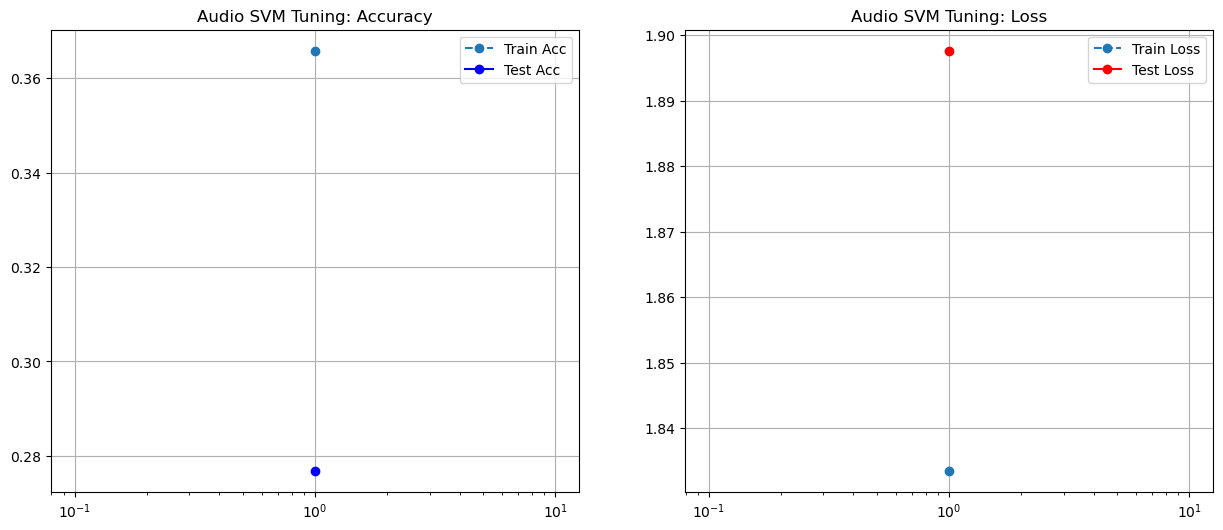

✅ Best Audio SVM C: 1


['svm_emotion_audio_model.pkl']

In [41]:
# Global lists for Audio
global test_acc_svm_audio_normal, test_loss_svm_audio_normal
train_acc_svm_audio_normal, test_acc_svm_audio_normal = [], []
train_loss_svm_audio_normal, test_loss_svm_audio_normal = [], []

print("🎤 Tuning SVM C-Value (Audio)...")

for c in c_values:
    # Audio often benefits from slightly lower C to handle noise
    clf = SVC(C=c, kernel='rbf', gamma='scale', probability=True, random_state=42)
    clf.fit(X_train_audio, y_train_audio)
    
    y_probs_train = clf.predict_proba(X_train_audio)
    y_probs_test = clf.predict_proba(X_test_audio)
    
    train_acc_svm_audio_normal.append(accuracy_score(y_train_audio, clf.predict(X_train_audio)))
    test_acc_svm_audio_normal.append(accuracy_score(y_test_audio, clf.predict(X_test_audio)))
    
    train_loss_svm_audio_normal.append(log_loss(y_train_audio, y_probs_train))
    test_loss_svm_audio_normal.append(log_loss(y_test_audio, y_probs_test))
    
    print(f"   C={c}: Train Acc={train_acc_svm_audio_normal[-1]:.2f} | Test Acc={test_acc_svm_audio_normal[-1]:.2f} | Test Loss={test_loss_svm_audio_normal[-1]:.2f}")

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(c_values, train_acc_svm_audio_normal, label='Train Acc', marker='o', linestyle='--')
ax1.plot(c_values, test_acc_svm_audio_normal, label='Test Acc', marker='o', color='blue')
ax1.set_xscale('log')
ax1.set_title('Audio SVM Tuning: Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(c_values, train_loss_svm_audio_normal, label='Train Loss', marker='o', linestyle='--')
ax2.plot(c_values, test_loss_svm_audio_normal, label='Test Loss', marker='o', color='red')
ax2.set_xscale('log')
ax2.set_title('Audio SVM Tuning: Loss')
ax2.legend()
ax2.grid(True)

plt.show()

# Save Best Audio Model
best_idx_a = np.argmax(test_acc_svm_audio_normal)
best_c_a = c_values[best_idx_a]
print(f"✅ Best Audio SVM C: {best_c_a}")

final_svm_audio = SVC(C=best_c_a, kernel='rbf', gamma='scale', probability=True, random_state=42)
final_svm_audio.fit(X_train_audio, y_train_audio)
joblib.dump(final_svm_audio, 'svm_emotion_audio_model.pkl')

In [42]:
# if 'test_loss_svm_audio_normal' not in globals():
#     print("⚠️ STOP: Run Audio Cell 1 first!")
# else:
#     train_acc_svm_audio_robust = []
#     test_acc_svm_audio_robust = []
#     train_loss_svm_audio_robust = []
#     test_loss_svm_audio_robust = []
    
#     print("🛡️ Tuning Robust Audio SVM...")

#     for c in c_values:
#         # ROBUST AUDIO: Gamma=0.01 provides smoothing for noisy audio features
#         clf = SVC(C=c, kernel='rbf', gamma=0.01, probability=True, random_state=42)
#         clf.fit(X_train_audio, y_train_audio)
        
#         y_probs_train = clf.predict_proba(X_train_audio)
#         y_probs_test = clf.predict_proba(X_test_audio)
        
#         train_acc_svm_audio_robust.append(accuracy_score(y_train_audio, clf.predict(X_train_audio)))
#         test_acc_svm_audio_robust.append(accuracy_score(y_test_audio, clf.predict(X_test_audio)))
        
#         train_loss_svm_audio_robust.append(log_loss(y_train_audio, y_probs_train))
#         test_loss_svm_audio_robust.append(log_loss(y_test_audio, y_probs_test))
        
#         print(f"   C={c}: Train Acc={train_acc_svm_audio_robust[-1]:.2f} | Test Acc={test_acc_svm_audio_robust[-1]:.2f} | Test Loss={test_loss_svm_audio_robust[-1]:.2f}")

#     # --- COMPARISON PLOTS ---
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

#     # Accuracy
#     ax1.plot(c_values, test_acc_svm_audio_normal, label='Normal (Gamma=Scale)', marker='o', color='blue', alpha=0.5)
#     ax1.plot(c_values, test_acc_svm_audio_robust, label='Robust (Gamma=0.01)', marker='s', color='green', linewidth=2)
#     ax1.plot(c_values, train_acc_svm_audio_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
#     ax1.plot(c_values, train_acc_svm_audio_normal, label='Normal Train', marker='o', linestyle='--', color='blue', alpha=0.3)
    
#     ax1.set_xscale('log')
#     ax1.set_title('Audio SVM Accuracy: Normal vs Robust')
#     ax1.legend()
#     ax1.grid(True)

#     # Loss
#     ax2.plot(c_values, test_loss_svm_audio_normal, label='Normal (Gamma=Scale)', marker='o', color='blue', alpha=0.5)
#     ax2.plot(c_values, test_loss_svm_audio_robust, label='Robust (Gamma=0.01)', marker='s', color='green', linewidth=2)
#     ax2.plot(c_values, train_loss_svm_audio_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
    
#     ax2.set_xscale('log')
#     ax2.set_title('Audio SVM Loss: Normal vs Robust')
#     ax2.legend()
#     ax2.grid(True)

#     plt.show()

# Naive-Bayes

⚡ Tuning Naive Bayes (var_smoothing)...


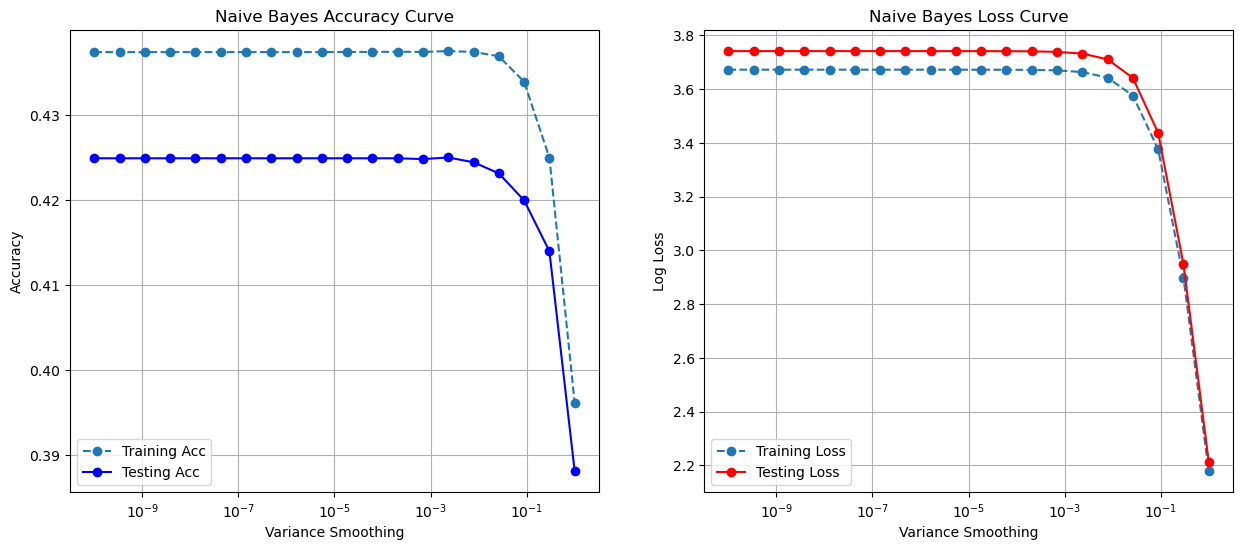

✅ Best var_smoothing: 2.34e-03
   Best Test Accuracy: 0.4250
💾 Saved best model as 'nb_emotion_video_model.pkl'


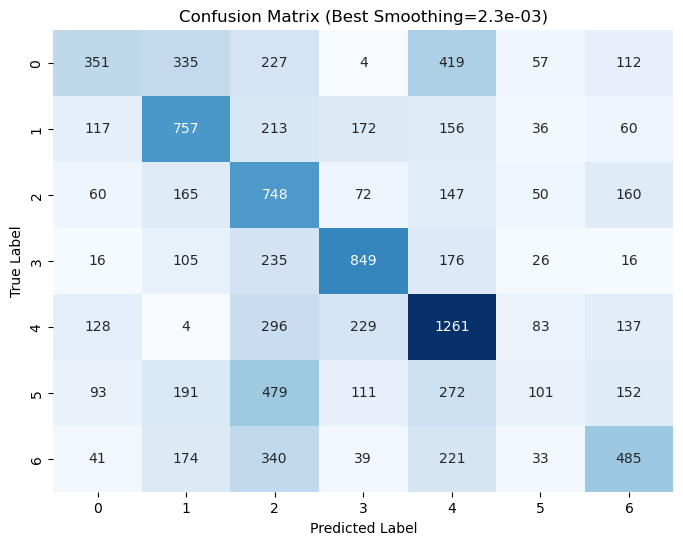

In [43]:

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

# --- 1. SETUP TUNING RANGE ---
# We need this variable to be the X-axis of our plots
# It creates 20 points between 0.0000000001 and 1.0
smoothing_values = np.logspace(-10, 0, 20) 

# Lists to store results for plotting
train_acc_nb = []
test_acc_nb = []
train_loss_nb = []
test_loss_nb = []

print("⚡ Tuning Naive Bayes (var_smoothing)...")

# --- 2. TRAINING LOOP ---
for v in smoothing_values:
    # Create model with specific smoothing value
    nbModel = GaussianNB(var_smoothing=v)
    nbModel.fit(X_train, y_train)
    
    # Measure Performance
    y_probs_train = nbModel.predict_proba(X_train)
    y_probs_test = nbModel.predict_proba(X_test)
    
    train_acc_nb.append(accuracy_score(y_train, nbModel.predict(X_train)))
    test_acc_nb.append(accuracy_score(y_test, nbModel.predict(X_test)))
    
    train_loss_nb.append(log_loss(y_train, y_probs_train))
    test_loss_nb.append(log_loss(y_test, y_probs_test))

# --- 3. PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy Plot
ax1.plot(smoothing_values, train_acc_nb, label='Training Acc', marker='o', linestyle='--')
ax1.plot(smoothing_values, test_acc_nb, label='Testing Acc', marker='o', color='blue')
ax1.set_xscale('log') # Log scale is crucial for var_smoothing
ax1.set_title('Naive Bayes Accuracy Curve')
ax1.set_xlabel('Variance Smoothing')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss Plot
ax2.plot(smoothing_values, train_loss_nb, label='Training Loss', marker='o', linestyle='--')
ax2.plot(smoothing_values, test_loss_nb, label='Testing Loss', marker='o', color='red')
ax2.set_xscale('log')
ax2.set_title('Naive Bayes Loss Curve')
ax2.set_xlabel('Variance Smoothing')
ax2.set_ylabel('Log Loss')
ax2.legend()
ax2.grid(True)

plt.show()

# --- 4. SAVE BEST MODEL ---
# Find the smoothing value that gave the highest Test Accuracy
best_idx = np.argmax(test_acc_nb)
best_v = smoothing_values[best_idx]
print(f"✅ Best var_smoothing: {best_v:.2e}")
print(f"   Best Test Accuracy: {test_acc_nb[best_idx]:.4f}")

final_nb = GaussianNB(var_smoothing=best_v)
final_nb.fit(X_train, y_train)
joblib.dump(final_nb, 'nb_emotion_video_model.pkl')
print("💾 Saved best model as 'nb_emotion_video_model.pkl'")

# --- 5. VISUALIZE MISTAKES ---
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, final_nb.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Best Smoothing={best_v:.1e})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

🎤 Tuning Naive Bayes (Audio)...


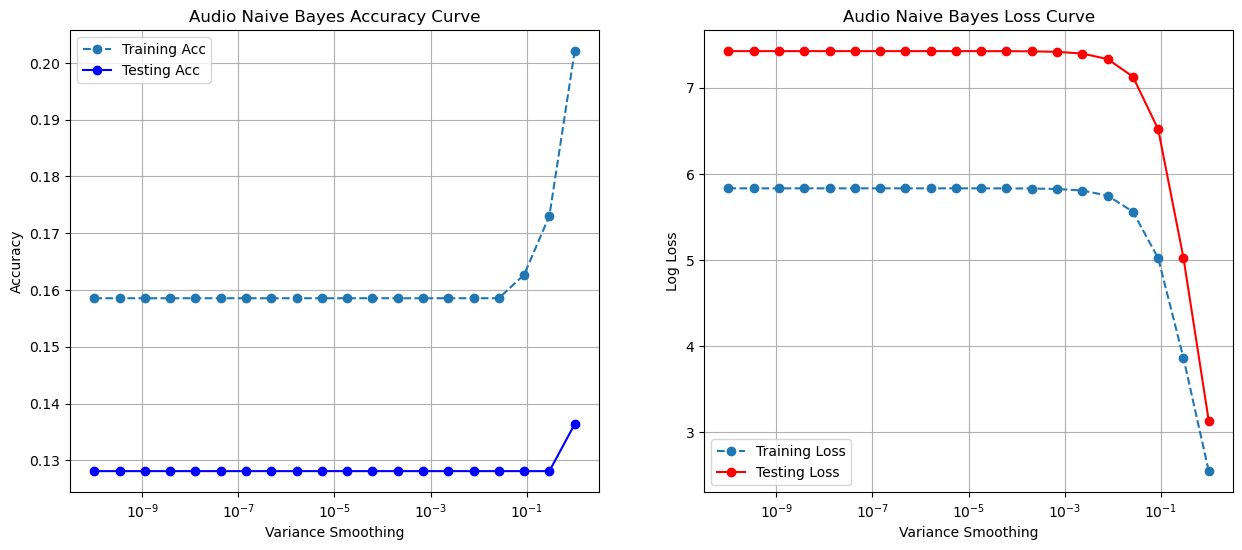

✅ Best Audio var_smoothing: 1.00e+00
   Best Test Accuracy: 0.1364
💾 Saved best audio model as 'nb_emotion_audio_model.pkl'


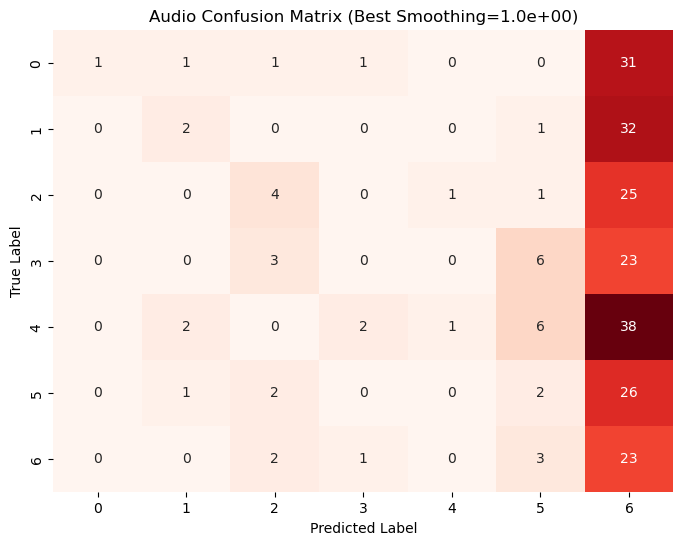

In [44]:

# --- 1. SETUP TUNING RANGE ---
# Define smoothing_values for the X-axis (from 10^-10 to 1.0)
smoothing_values = np.logspace(-10, 0, 20) 

# Lists to store results for plotting
train_acc_nb_audio = []
test_acc_nb_audio = []
train_loss_nb_audio = []
test_loss_nb_audio = []

print("🎤 Tuning Naive Bayes (Audio)...")

# --- 2. TRAINING LOOP ---
for v in smoothing_values:
    # Create model with specific smoothing value
    clf_audio = GaussianNB(var_smoothing=v)
    clf_audio.fit(X_train_audio, y_train_audio)
    
    # Measure Performance
    y_probs_train = clf_audio.predict_proba(X_train_audio)
    y_probs_test = clf_audio.predict_proba(X_test_audio)
    
    train_acc_nb_audio.append(accuracy_score(y_train_audio, clf_audio.predict(X_train_audio)))
    test_acc_nb_audio.append(accuracy_score(y_test_audio, clf_audio.predict(X_test_audio)))
    
    train_loss_nb_audio.append(log_loss(y_train_audio, y_probs_train))
    test_loss_nb_audio.append(log_loss(y_test_audio, y_probs_test))

# --- 3. PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy Plot
ax1.plot(smoothing_values, train_acc_nb_audio, label='Training Acc', marker='o', linestyle='--')
ax1.plot(smoothing_values, test_acc_nb_audio, label='Testing Acc', marker='o', color='blue')
ax1.set_xscale('log') # Log scale is crucial for var_smoothing
ax1.set_title('Audio Naive Bayes Accuracy Curve')
ax1.set_xlabel('Variance Smoothing')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss Plot
ax2.plot(smoothing_values, train_loss_nb_audio, label='Training Loss', marker='o', linestyle='--')
ax2.plot(smoothing_values, test_loss_nb_audio, label='Testing Loss', marker='o', color='red')
ax2.set_xscale('log')
ax2.set_title('Audio Naive Bayes Loss Curve')
ax2.set_xlabel('Variance Smoothing')
ax2.set_ylabel('Log Loss')
ax2.legend()
ax2.grid(True)

plt.show()

# --- 4. SAVE BEST MODEL ---
# Find the smoothing value that gave the highest Test Accuracy
best_idx_a = np.argmax(test_acc_nb_audio)
best_v_a = smoothing_values[best_idx_a]
print(f"✅ Best Audio var_smoothing: {best_v_a:.2e}")
print(f"   Best Test Accuracy: {test_acc_nb_audio[best_idx_a]:.4f}")

final_nb_audio = GaussianNB(var_smoothing=best_v_a)
final_nb_audio.fit(X_train_audio, y_train_audio)
joblib.dump(final_nb_audio, 'nb_emotion_audio_model.pkl')
print("💾 Saved best audio model as 'nb_emotion_audio_model.pkl'")

# --- 5. VISUALIZE MISTAKES ---
plt.figure(figsize=(8, 6))
cm_audio = confusion_matrix(y_test_audio, final_nb_audio.predict(X_test_audio))
sns.heatmap(cm_audio, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title(f'Audio Confusion Matrix (Best Smoothing={best_v_a:.1e})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Logistic Regression

VIDEO | LR (no reg)
Accuracy: train=0.7734, test=0.7686
LogLoss : train=0.6364, test=0.6471


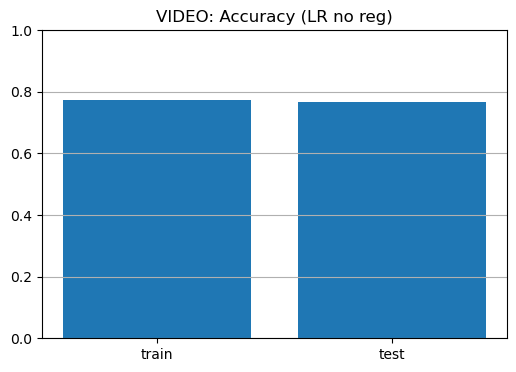

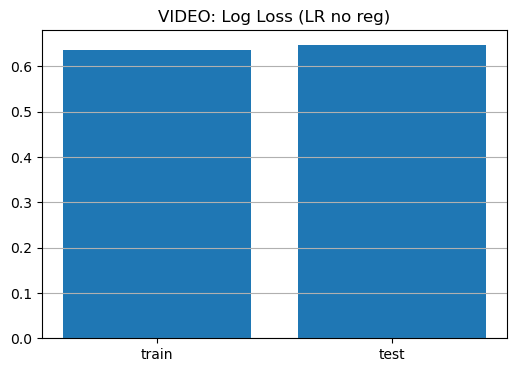

✅ Model saved successfully to: video_logistic_regression.pkl


In [45]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

video_plain = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        penalty=None,
        solver="lbfgs",
        max_iter=2500,
        random_state=42
    ))
])

video_plain.fit(X_train, y_train)

video_train_acc = accuracy_score(y_train, video_plain.predict(X_train))
video_test_acc  = accuracy_score(y_test,  video_plain.predict(X_test))

video_train_loss = log_loss(y_train, video_plain.predict_proba(X_train))
video_test_loss  = log_loss(y_test,  video_plain.predict_proba(X_test))

print("VIDEO | LR (no reg)")
print(f"Accuracy: train={video_train_acc:.4f}, test={video_test_acc:.4f}")
print(f"LogLoss : train={video_train_loss:.4f}, test={video_test_loss:.4f}")

plt.figure(figsize=(6,4))
plt.bar(["train","test"], [video_train_acc, video_test_acc])
plt.ylim(0,1)
plt.title("VIDEO: Accuracy (LR no reg)")
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(["train","test"], [video_train_loss, video_test_loss])
plt.title("VIDEO: Log Loss (LR no reg)")
plt.grid(axis="y")
plt.show()

model_filename = "video_logistic_regression.pkl"
joblib.dump(video_plain, model_filename)
print(f"✅ Model saved successfully to: {model_filename}")

In [46]:


# C_grid = np.logspace(-3, 3, 9)  # 1e-3 ... 1e3

# vid_train_accs, vid_test_accs = [], []
# vid_train_losses, vid_test_losses = [], []

# for C in C_grid:
#     video_l2 = Pipeline([
#         ("scaler", StandardScaler()),
#         ("lr", LogisticRegression(
#             penalty="l2",
#             C=float(C),
#             solver="lbfgs",
#             max_iter=2500,
#             random_state=42
#         ))
#     ])

#     video_l2.fit(X_train, y_train)

#     vid_train_accs.append(accuracy_score(y_train, video_l2.predict(X_train)))
#     vid_test_accs.append(accuracy_score(y_test,  video_l2.predict(X_test)))

#     vid_train_losses.append(log_loss(y_train, video_l2.predict_proba(X_train)))
#     vid_test_losses.append(log_loss(y_test,  video_l2.predict_proba(X_test)))

# best_idx = int(np.argmin(vid_test_losses))
# print("VIDEO | LR (L2)")
# print(f"Best C (lowest test log loss) = {C_grid[best_idx]:.4g}")
# print(f"Best test log loss = {vid_test_losses[best_idx]:.4f}")

# plt.figure(figsize=(8,5))
# plt.plot(C_grid, vid_train_accs, marker="o", label="train acc")
# plt.plot(C_grid, vid_test_accs, marker="o", label="test acc")
# plt.xscale("log")
# plt.xlabel("C (bigger = weaker regularization)")
# plt.ylabel("accuracy")
# plt.title("VIDEO: Accuracy vs C (LR L2)")
# plt.grid(True)
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,5))
# plt.plot(C_grid, vid_train_losses, marker="o", linestyle="--", label="train log loss")
# plt.plot(C_grid, vid_test_losses, marker="o", label="test log loss")
# plt.xscale("log")
# plt.xlabel("C (bigger = weaker regularization)")
# plt.ylabel("log loss (lower is better)")
# plt.title("VIDEO: Log Loss vs C (LR L2)")
# plt.grid(True)
# plt.legend()
# plt.show()


AUDIO | LR (no reg)
Accuracy: train=0.3699, test=0.2521
LogLoss : train=1.5266, test=4.5336


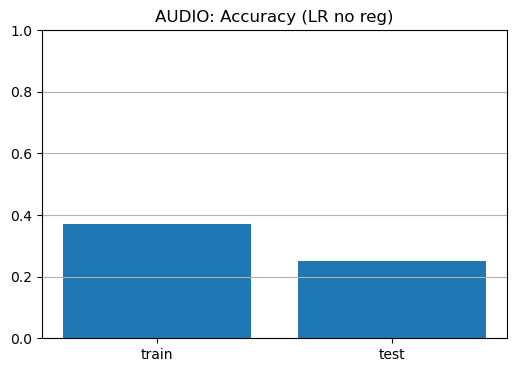

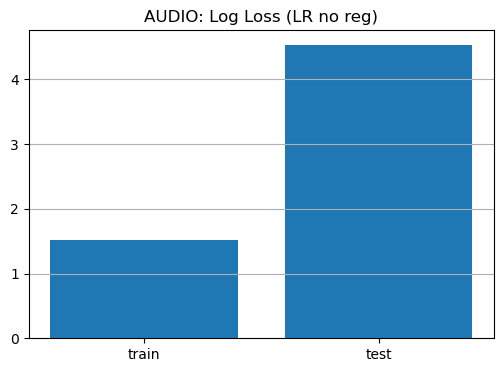

✅ Model saved successfully to: audio_logistic_regression.pkl


In [47]:
import joblib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# --- MODEL DEFINITION ---
audio_plain = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        penalty=None,
        solver="lbfgs",
        max_iter=2500,
        random_state=42
    ))
])

# --- TRAINING ---
audio_plain.fit(X_train_audio, y_train_audio)

# --- EVALUATION ---
audio_train_acc = accuracy_score(y_train_audio, audio_plain.predict(X_train_audio))
audio_test_acc  = accuracy_score(y_test_audio,  audio_plain.predict(X_test_audio))

audio_train_loss = log_loss(y_train_audio, audio_plain.predict_proba(X_train_audio))
audio_test_loss  = log_loss(y_test_audio,  audio_plain.predict_proba(X_test_audio))

print("AUDIO | LR (no reg)")
print(f"Accuracy: train={audio_train_acc:.4f}, test={audio_test_acc:.4f}")
print(f"LogLoss : train={audio_train_loss:.4f}, test={audio_test_loss:.4f}")

# --- PLOTTING ---
plt.figure(figsize=(6,4))
plt.bar(["train","test"], [audio_train_acc, audio_test_acc])
plt.ylim(0,1)
plt.title("AUDIO: Accuracy (LR no reg)")
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(["train","test"], [audio_train_loss, audio_test_loss])
plt.title("AUDIO: Log Loss (LR no reg)")
plt.grid(axis="y")
plt.show()

# --- SAVE THE MODEL ---
model_filename = "audio_logistic_regression.pkl"
joblib.dump(audio_plain, model_filename)
print(f"✅ Model saved successfully to: {model_filename}")

In [48]:
# aud_train_accs, aud_test_accs = [], []
# aud_train_losses, aud_test_losses = [], []

# for C in C_grid:
#     audio_l2 = Pipeline([
#         ("scaler", StandardScaler()),
#         ("lr", LogisticRegression(
#             penalty="l2",
#             C=float(C),
#             solver="lbfgs",
#             max_iter=2500,
#             random_state=42
#         ))
#     ])

#     audio_l2.fit(X_train_audio, y_train_audio)

#     aud_train_accs.append(accuracy_score(y_train_audio, audio_l2.predict(X_train_audio)))
#     aud_test_accs.append(accuracy_score(y_test_audio,  audio_l2.predict(X_test_audio)))

#     aud_train_losses.append(log_loss(y_train_audio, audio_l2.predict_proba(X_train_audio)))
#     aud_test_losses.append(log_loss(y_test_audio,  audio_l2.predict_proba(X_test_audio)))

# best_idx = int(np.argmin(aud_test_losses))
# print("AUDIO | LR (L2)")
# print(f"Best C (lowest test log loss) = {C_grid[best_idx]:.4g}")
# print(f"Best test log loss = {aud_test_losses[best_idx]:.4f}")

# plt.figure(figsize=(8,5))
# plt.plot(C_grid, aud_train_accs, marker="o", label="train acc")
# plt.plot(C_grid, aud_test_accs, marker="o", label="test acc")
# plt.xscale("log")
# plt.xlabel("C (bigger = weaker regularization)")
# plt.ylabel("accuracy")
# plt.title("AUDIO: Accuracy vs C (LR L2)")
# plt.grid(True)
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,5))
# plt.plot(C_grid, aud_train_losses, marker="o", linestyle="--", label="train log loss")
# plt.plot(C_grid, aud_test_losses, marker="o", label="test log loss")
# plt.xscale("log")
# plt.xlabel("C (bigger = weaker regularization)")
# plt.ylabel("log loss (lower is better)")
# plt.title("AUDIO: Log Loss vs C (LR L2)")
# plt.grid(True)
# plt.legend()
# plt.show()


# APPLICATION

In [49]:
import joblib
import numpy as np
import threading
import time
import soundfile as sf
import sounddevice as sd
import cv2
import os
import mediapipe as mp
from collections import deque

# ==============================
# CONFIGURATION
# ==============================
CHUNK_DURATION = 3.0
SAMPLE_RATE = 22050
TEMP_AUDIO_FILE = "live_input.wav"

# SMOOTHING CONFIG
# EMA_ALPHA: 0.05 (very smooth/slow) to 0.3 (fast/more jitter)
# 0.12 is the sweet spot for a "professional" fluid feel.
EMA_ALPHA = 0.12  

# ==============================
# GLOBAL STATE
# ==============================
is_running = True
raw_audio_prob = 0.0
raw_audio_label = "Listening..."
raw_video_prob = 0.0
raw_video_label = "Waiting..."

# Smooth state variables for the UI interpolation
ui_video_prob = 0.0
ui_audio_prob = 0.0
ui_fusion_prob = 0.0

# ==============================
# FEATURE EXTRACTORS
# ==============================
class AudioFeatureExtractor:
    def get_features(self, audio_path):
        # Replace with actual extraction logic if needed
        return np.random.rand(120).tolist()

class EmotionFeatureExtractor:
    def __init__(self):
        self.face_mesh = mp.solutions.face_mesh.FaceMesh(
            static_image_mode=False,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5
        )

    def get_features(self, frame):
        # Replace with actual extraction logic if needed
        return np.random.rand(50).tolist()

# ==============================
# ANGRY METER ENGINE
# ==============================
class AngryMeter:
    def __init__(self):
        try:
            self.audio_le = joblib.load('label_encoder_audio.pkl')
            self.video_le = joblib.load('label_encoder.pkl')
        except Exception as e:
            print(f"⚠️ Warning: Encoders not found. Ensure .pkl files are in the directory. Error: {e}")

        self.audio_extractor = AudioFeatureExtractor()
        self.video_extractor = EmotionFeatureExtractor()

        # Try to find 'angry' index
        try:
            self.audio_angry_idx = list(self.audio_le.classes_).index('angry')
            self.video_angry_idx = list(self.video_le.classes_).index('angry')
        except:
            self.audio_angry_idx = 0
            self.video_angry_idx = 0

        self.available_video_models = {
            'lr': 'video_logistic_regression.pkl',
            'svm': 'svm_emotion_video_model.pkl',
            'knn': 'knn_emotion_video_normal.pkl',
            'nb': 'nb_emotion_video_model.pkl',
            'tree': 'best_tree_depth_15.pkl'
        }
        self.available_audio_models = {
            'svm': 'svm_emotion_audio_model.pkl',
            'knn': 'knn_emotion_audio_model.pkl',
            'nb': 'nb_emotion_audio_model.pkl',
            'tree': 'best_tree_depth_1_audio.pkl',
            'lr': 'audio_logistic_regression.pkl'
        }

        self.current_model_key = "LR"
        self.load_models("lr")

    def load_models(self, model_key):
        success_v = success_a = False
        try:
            if model_key in self.available_video_models:
                self.video_model = joblib.load(self.available_video_models[model_key])
                success_v = True
            if model_key in self.available_audio_models:
                self.audio_model = joblib.load(self.available_audio_models[model_key])
                success_a = True
            self.current_model_key = model_key.upper()
        except: pass
        return success_v and success_a

    def _reshape_features(self, features, expected_size):
        features = np.array(features).flatten()
        if len(features) == expected_size: return features
        return np.pad(features, (0, max(0, expected_size - len(features))), mode='constant')[:expected_size]

    def get_audio_prediction(self, audio_path):
        try:
            features = self.audio_extractor.get_features(audio_path)
            if not features: return 0.0, "Silence"
            if hasattr(self.audio_model, 'n_features_in_'):
                features = self._reshape_features(features, self.audio_model.n_features_in_)
            probs = self.audio_model.predict_proba(features.reshape(1, -1))[0]
            return float(probs[self.audio_angry_idx]), str(self.audio_le.inverse_transform([np.argmax(probs)])[0])
        except: return 0.0, "Error"

    def get_video_prediction(self, frame):
        try:
            vector = self.video_extractor.get_features(frame)
            if vector is None: return 0.0, "No Face"
            if hasattr(self.video_model, 'n_features_in_'):
                vector = self._reshape_features(vector, self.video_model.n_features_in_)
            probs = self.video_model.predict_proba(vector.reshape(1, -1))[0]
            return float(probs[self.video_angry_idx]), str(self.video_le.inverse_transform([np.argmax(probs)])[0])
        except: return 0.0, "Error"

# ==============================
# WORKERS & UI
# ==============================
def audio_listener(fusion_engine):
    global raw_audio_prob, raw_audio_label, is_running
    while is_running:
        try:
            recording = sd.rec(int(CHUNK_DURATION * SAMPLE_RATE), samplerate=SAMPLE_RATE, channels=1, dtype='float32')
            sd.wait()
            if np.sqrt(np.mean(recording**2)) < 0.01:
                raw_audio_prob, raw_audio_label = 0.0, "Silence"
                continue
            sf.write(TEMP_AUDIO_FILE, recording, SAMPLE_RATE)
            raw_audio_prob, raw_audio_label = fusion_engine.get_audio_prediction(TEMP_AUDIO_FILE)
        except: time.sleep(1)

def apply_ema(new_val, old_val, alpha):
    """Signal smoothing logic: """
    return (alpha * new_val) + ((1 - alpha) * old_val)

def draw_meter_bar(img, x, y, width, height, current_val, label):
    # Bar background
    cv2.rectangle(img, (x, y), (x + width, y + height), (40, 40, 40), -1)
    # Smooth fill
    fill_w = int(width * current_val)
    # Color: BGR - transitions from Green (0,255,0) to Red (0,0,255)
    color = (0, int(255 * (1 - current_val)), int(255 * current_val))
    cv2.rectangle(img, (x, y), (x + fill_w, y + height), color, -1)
    cv2.rectangle(img, (x, y), (x + width, y + height), (200, 200, 200), 1)
    cv2.putText(img, f"{label}: {current_val:.0%}", (x, y - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

def main():
    global raw_audio_prob, raw_audio_label, ui_video_prob, ui_audio_prob, ui_fusion_prob, is_running
    
    meter = AngryMeter()
    threading.Thread(target=audio_listener, args=(meter,), daemon=True).start()
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret: break
        frame = cv2.flip(frame, 1)
        h, w = frame.shape[:2]

        # 1. Get raw values
        v_prob, v_label = meter.get_video_prediction(frame)

        # 2. APPLY DOUBLE SMOOTHING (The Jitter Fix)
        ui_video_prob = apply_ema(v_prob, ui_video_prob, EMA_ALPHA)
        # Audio updates slower (every 3s), so we use a smaller alpha for a longer "glide"
        ui_audio_prob = apply_ema(raw_audio_prob, ui_audio_prob, EMA_ALPHA * 0.4)
        
        target_fusion = (ui_video_prob + ui_audio_prob) / 2
        ui_fusion_prob = apply_ema(target_fusion, ui_fusion_prob, EMA_ALPHA)

        # 3. RENDER
        # Top HUD Panel
        overlay = frame.copy()
        cv2.rectangle(overlay, (0, 0), (w, 70), (0, 0, 0), -1)
        cv2.addWeighted(overlay, 0.5, frame, 0.5, 0, frame)
        
        cv2.putText(frame, f"VIDEO: {v_label}", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(frame, f"AUDIO: {raw_audio_label}", (20, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(frame, f"MODEL: {meter.current_model_key}", (w - 150, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

        # Bottom Bars
        bar_w = 300
        draw_meter_bar(frame, 30, h - 80, bar_w, 25, ui_video_prob, "FACIAL STRESS")
        
        # Central Fusion Meter
        draw_meter_bar(frame, int(w/2 - 150), h - 40, 300, 30, ui_fusion_prob, "TOTAL AGITATION")

        cv2.imshow("AngryMeter Pro - Ultra Smooth", frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'): break
        elif ord('1') <= key <= ord('5'):
            keys = ['lr', 'svm', 'knn', 'nb', 'tree']
            meter.load_models(keys[key - ord('1')])

    is_running = False
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()